In [1]:
import meep as mp
import meep.adjoint as mpa
from meep import Animate2D
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from meep.materials import Ag
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
#from meep.materials import c-Si


os.makedirs(f'PICTURE',exist_ok=True)
mp.verbosity(0)
TiO2 = mp.Medium(index=2.6)
SiO2 = mp.Medium(index=1.44)
Si = mp.Medium(index=3.4)
Air = mp.Medium(index=1)

In [2]:
resolution = 100
design_region_resolution = int(resolution)

design_region_x_width  = 1   #100 nm
design_region_y_height = 1   #100 nm
design_region_z_height = 0.02  #20 nm or 10nm

pml_size = 1.0
pml_layers = [mp.PML(pml_size,direction=mp.Z)]

Sz_size = 0.6
Sx = design_region_x_width
Sy = design_region_y_height 
Sz = 2 * pml_size + design_region_z_height + Sz_size
cell_size = mp.Vector3(Sx, Sy, Sz)

wavelengths = np.array([1.55])     # wavelengths = np.array([1.5 ,1.55, 1.6])
frequencies = np.array([1 / 1.55])

nf = 1                 #3 #wavelengths Number

minimum_length = 0.02  # minimum length scale (microns)
eta_i = 0.5            # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55           # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e      # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

Source_distance = -0.2

fcen   = 1 / 1.55
width  = 0.2  
fwidth = width * fcen
source_center = mp.Vector3(0,0,Source_distance)  
source_size   = mp.Vector3(design_region_x_width, design_region_y_height, 0)
src    = mp.GaussianSource(frequency=fcen, fwidth=fwidth, is_integrated=True)
source = [mp.Source(src, component=mp.Ey, size=source_size, center=source_center)]   

Nx = int(design_region_resolution * design_region_x_width) + 1
Ny = int(design_region_resolution * design_region_y_height) + 1
Nz = 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny, Nz), Air, Si, grid_type="U_MEAN")
design_region    = mpa.DesignRegion(
            design_variables,
            volume=mp.Volume(
            center=mp.Vector3(0,0,0),
            size=mp.Vector3(design_region_x_width, design_region_y_height, design_region_z_height),
            ),
)

def mapping(x, eta, beta):
    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_x_width,
        design_region_y_height,
        design_region_resolution,
    )
    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)
    projected_field = (npa.fliplr(projected_field) + projected_field) / 2
    projected_field = (npa.flipud(projected_field) + projected_field) / 2  # left-right symmetry    
    
    return projected_field.flatten()


geometry = [mp.Block(center=design_region.center, size=design_region.size, material=design_variables)]

kpoint = mp.Vector3()
sim = mp.Simulation(
    cell_size        = cell_size,
    boundary_layers  = pml_layers,
    geometry         = geometry,
    sources          = source,
    default_material = Air,
    k_point          = kpoint,
    symmetries       = [mp.Mirror(direction=mp.X)],
    resolution       = resolution,
    extra_materials  = [Ag],       # Introducing metal complex terms
)
#---------------------------------------------------------------------------------------------------#


#-----------------[4]---------------------------------#
monitor_position   = mp.Vector3(0, 0, 0)       # Focus position
monitor_size       = mp.Vector3(0.01,0.01,design_region_z_height)     # Focus Size//////0.11
FourierFields_x    = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ex,yee_grid=True)
FourierFields_y    = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ey,yee_grid=True)
FourierFields_z    = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True)
ob_list            = [FourierFields_x,FourierFields_y,FourierFields_z]


def J(fields_x,fields_y,fields_z):
    ET_x = 0
    ET_y = 0
    ET_z = 0
    ET_x_length = fields_x.shape[1]
    ET_y_length = fields_y.shape[1]
    ET_z_length = fields_z.shape[1]
    for k in range(0,ET_x_length):
        ET_x = ET_x + npa.abs(fields_x[:,k]) ** 2
    for k in range(0,ET_y_length):
        ET_y = ET_y + npa.abs(fields_y[:,k]) ** 2
    for k in range(0,ET_z_length):
        ET_z = ET_z + npa.abs(fields_z[:,k]) ** 2
    ET = ( (npa.mean(ET_x)) + (npa.mean(ET_y)) + (npa.mean(ET_z)) ) ** (1/2)  
    return ET


opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    decimation_factor = 1 ,           # KEY BUG!!
    maximum_run_time=50,
)

[0.5 0.5 0.5 ... 0.5 0.5 0.5]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


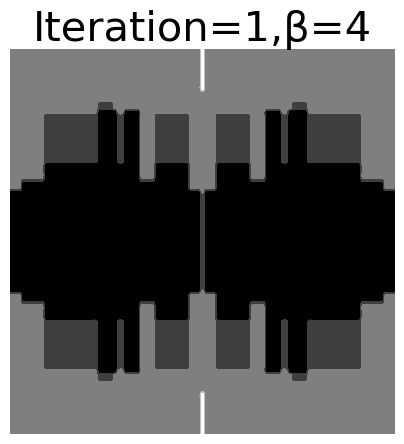

[0.50023177 0.500121   0.50012741 ... 0.50012741 0.500121   0.50023177]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


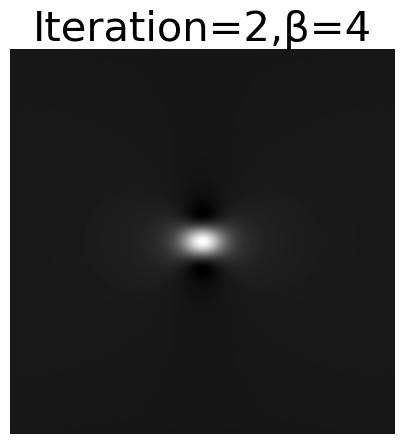

[0.5027132  0.50142214 0.50149732 ... 0.50149732 0.50142214 0.5027132 ]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


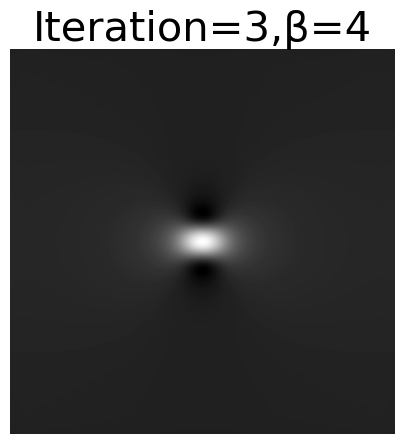

[0.55783867 0.53278879 0.53438352 ... 0.53438352 0.53278879 0.55783867]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


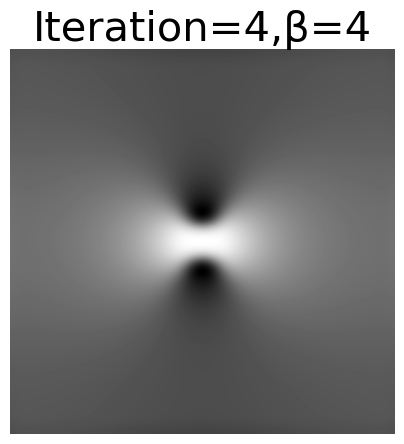

[1.         0.95756849 0.96734766 ... 0.96734766 0.95756849 1.        ]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


/home/ming/anaconda3/envs/mp/lib/python3.8/site-packages/meep/geom.py:588: UserWarning: The weights parameter of MaterialGrid must be in the range [0,1].
  warnings.warn(


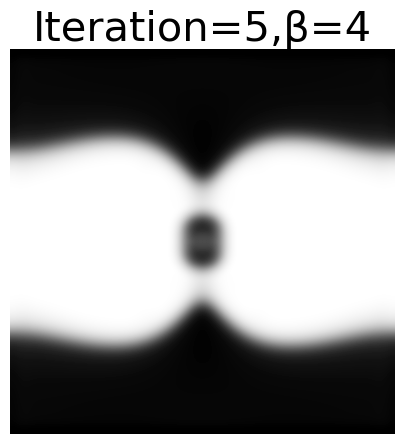

[0.78155148 0.68816618 0.69740776 ... 0.69740776 0.68816618 0.78155148]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


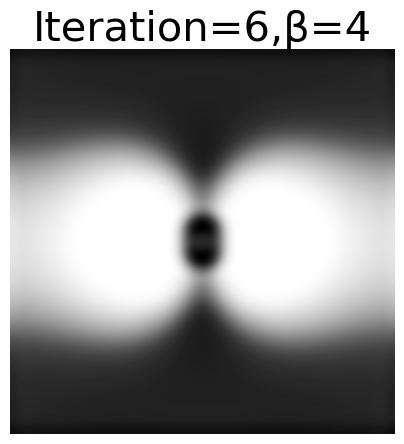

[0.59961846 0.55642326 0.55974079 ... 0.55974079 0.55642326 0.59961846]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


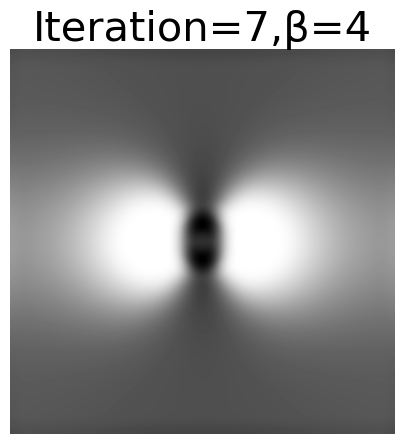

[0.56248665 0.53529781 0.53708733 ... 0.53708733 0.53529781 0.56248665]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


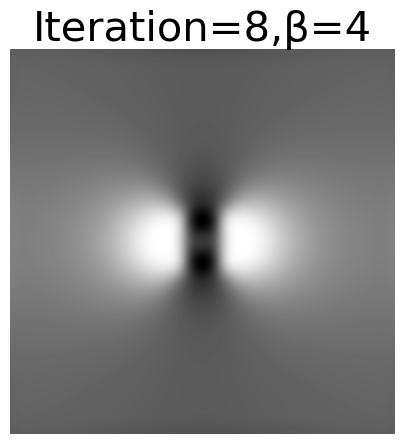

[0.55830891 0.53304127 0.53465573 ... 0.53465573 0.53304127 0.55830891]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


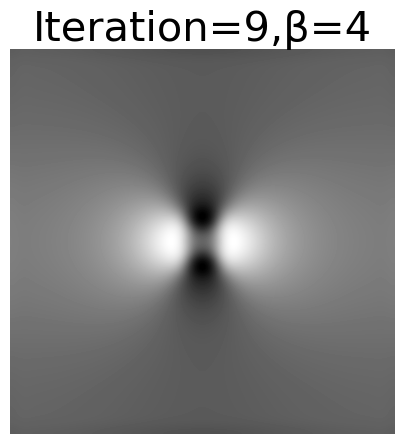

[0.55790557 0.53282468 0.53442222 ... 0.53442222 0.53282468 0.55790557]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


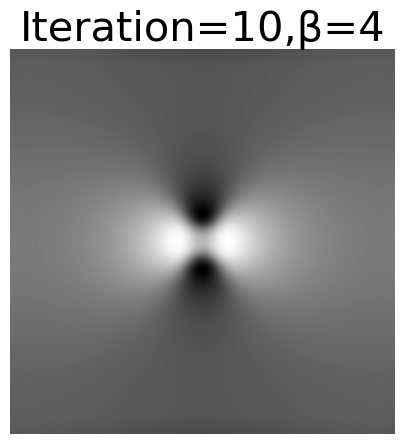

[0.55785656 0.53279839 0.53439387 ... 0.53439387 0.53279839 0.55785656]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


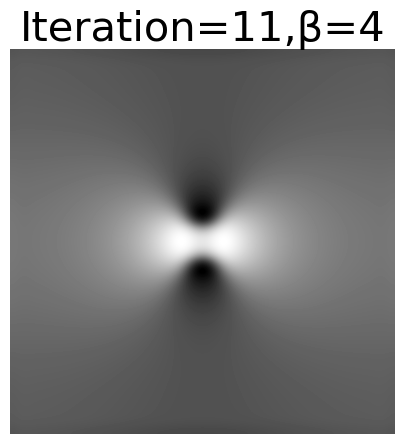

[0.55786747 0.53280422 0.53440014 ... 0.53440014 0.53280422 0.55786747]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


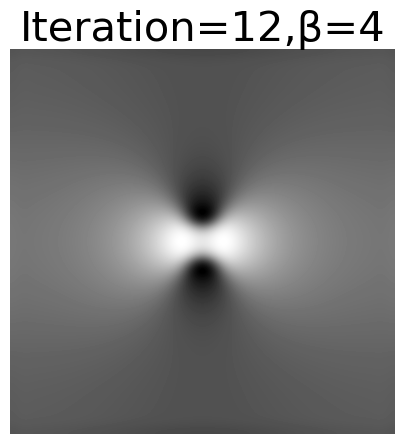

[0.55803455 0.5328937  0.53449637 ... 0.53449637 0.5328937  0.55803455]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


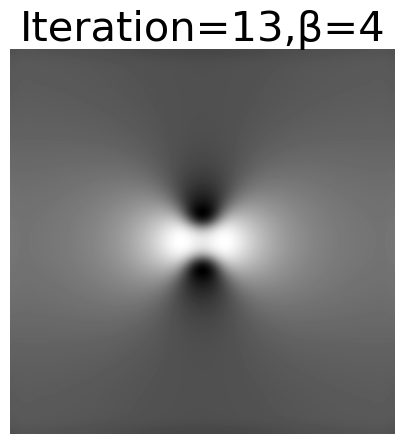

[0.56130909 0.53465374 0.53639062 ... 0.53639062 0.53465374 0.56130909]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


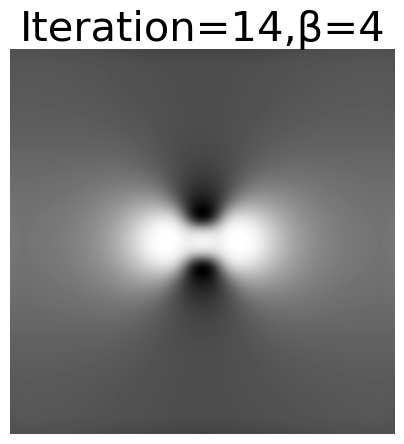

[0.56436942 0.53629131 0.5381429  ... 0.5381429  0.53629131 0.56436942]
2
0.5
4
[0.5 0.5 0.5 ... 0.5 0.5 0.5]


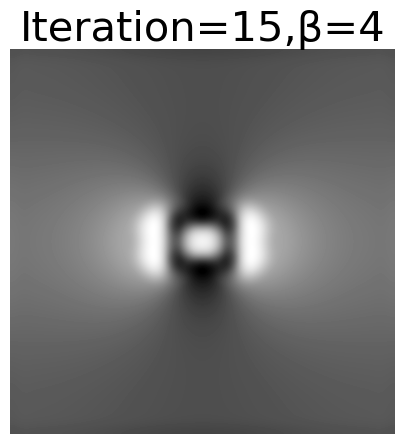

[0.56130909 0.53465374 0.53639062 ... 0.53639062 0.53465374 0.56130909]
2
0.5
8
[0.56130909 0.53465374 0.53639062 ... 0.53639062 0.53465374 0.56130909]


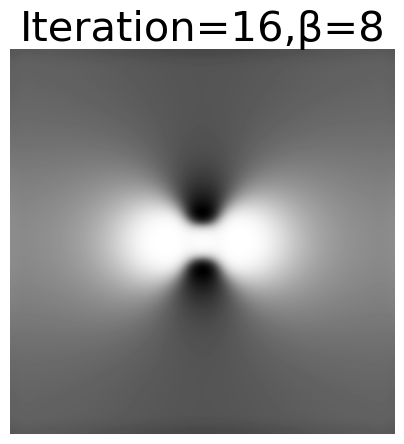

[0.56383721 0.5360419  0.53790249 ... 0.53790249 0.5360419  0.56383721]
2
0.5
8
[0.56130909 0.53465374 0.53639062 ... 0.53639062 0.53465374 0.56130909]


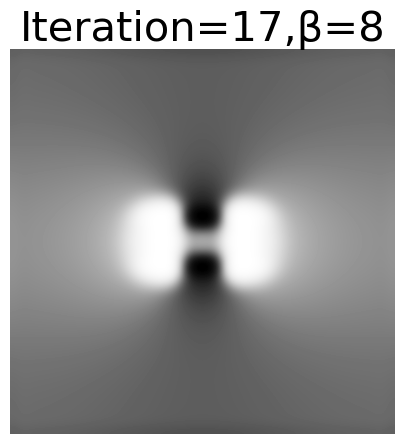

[0.56406581 0.53616833 0.53804201 ... 0.53804201 0.53616833 0.56406581]
2
0.5
8
[0.56130909 0.53465374 0.53639062 ... 0.53639062 0.53465374 0.56130909]


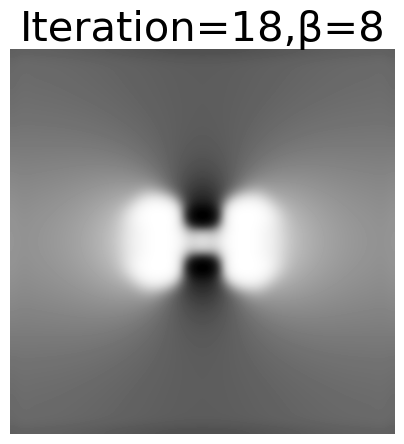

[0.56772134 0.53818035 0.5402314  ... 0.5402314  0.53818035 0.56772134]
2
0.5
8
[0.56130909 0.53465374 0.53639062 ... 0.53639062 0.53465374 0.56130909]


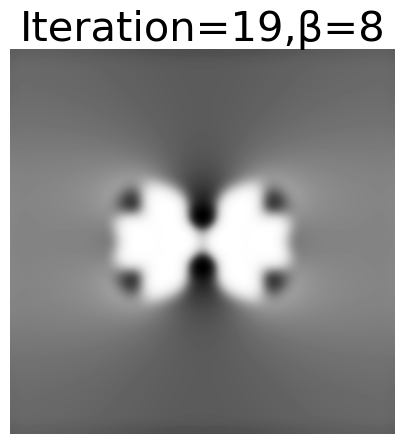

[0.56448125 0.53639566 0.53828953 ... 0.53828953 0.53639566 0.56448125]
2
0.5
8
[0.56130909 0.53465374 0.53639062 ... 0.53639062 0.53465374 0.56130909]


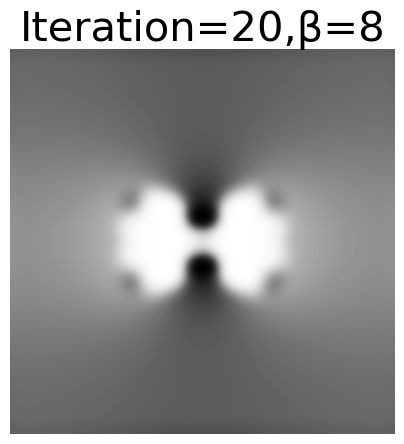

[0.5649901  0.53667455 0.53859372 ... 0.53859372 0.53667455 0.5649901 ]
2
0.5
8
[0.56130909 0.53465374 0.53639062 ... 0.53639062 0.53465374 0.56130909]


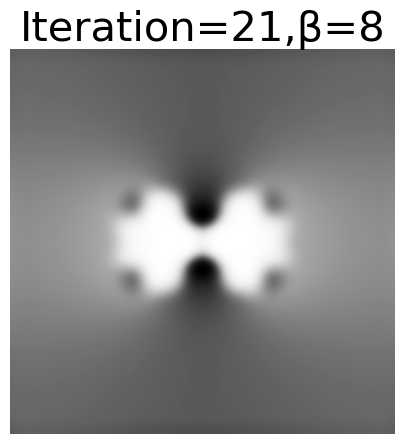

[0.56460725 0.53646466 0.5383648  ... 0.5383648  0.53646466 0.56460725]
2
0.5
8
[0.56130909 0.53465374 0.53639062 ... 0.53639062 0.53465374 0.56130909]


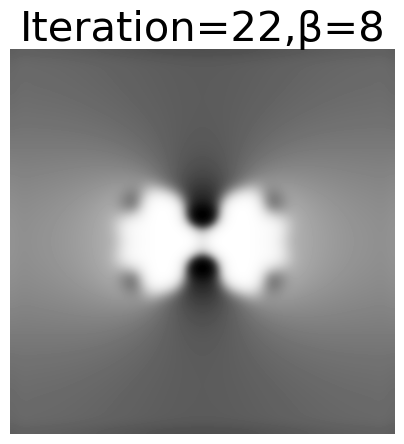

[0.56479942 0.53657012 0.53848008 ... 0.53848008 0.53657012 0.56479942]
2
0.5
8
[0.56130909 0.53465374 0.53639062 ... 0.53639062 0.53465374 0.56130909]


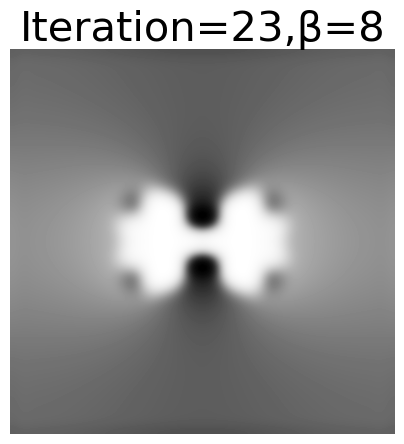

[0.564669   0.53649854 0.53840184 ... 0.53840184 0.53649854 0.564669  ]
2
0.5
8
[0.56130909 0.53465374 0.53639062 ... 0.53639062 0.53465374 0.56130909]


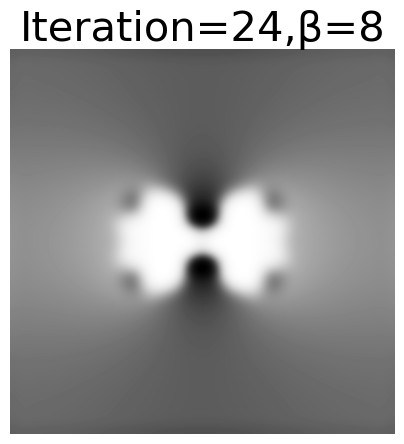

[0.56469912 0.53651508 0.53841992 ... 0.53841992 0.53651508 0.56469912]
2
0.5
8
[0.56130909 0.53465374 0.53639062 ... 0.53639062 0.53465374 0.56130909]


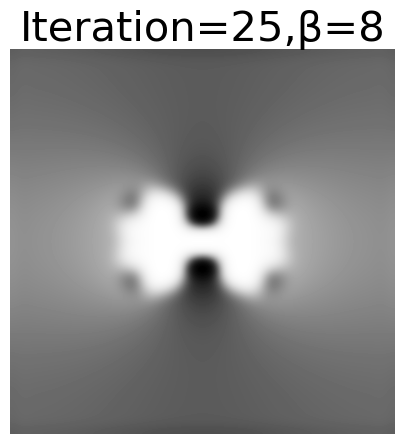

[0.56467471 0.53650168 0.53840527 ... 0.53840527 0.53650168 0.56467471]
2
0.5
8
[0.56130909 0.53465374 0.53639062 ... 0.53639062 0.53465374 0.56130909]


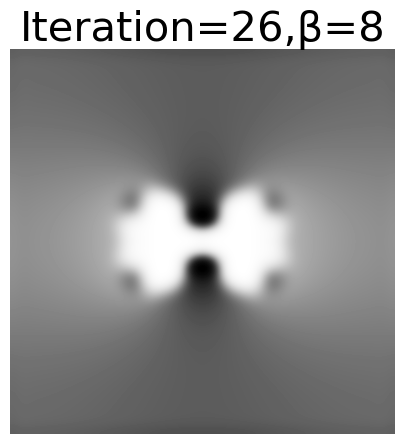

[0.56467088 0.53649958 0.53840297 ... 0.53840297 0.53649958 0.56467088]
2
0.5
8
[0.56130909 0.53465374 0.53639062 ... 0.53639062 0.53465374 0.56130909]


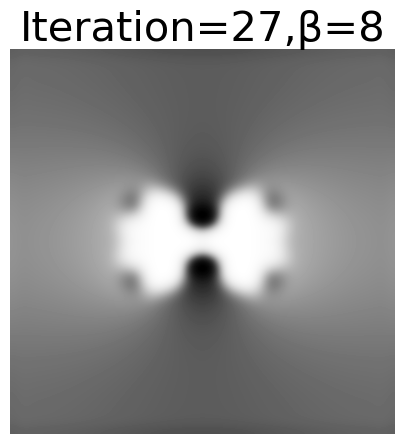

[0.56466973 0.53649895 0.53840228 ... 0.53840228 0.53649895 0.56466973]
2
0.5
8
[0.56130909 0.53465374 0.53639062 ... 0.53639062 0.53465374 0.56130909]


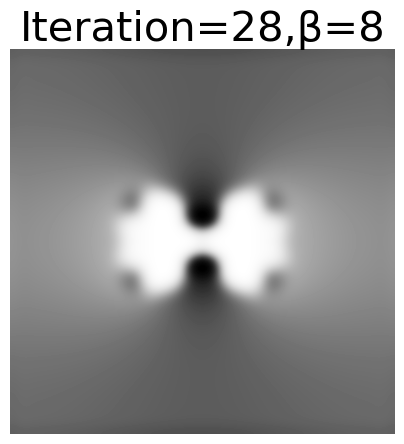

[0.5646693  0.53649871 0.53840202 ... 0.53840202 0.53649871 0.5646693 ]
2
0.5
8
[0.56130909 0.53465374 0.53639062 ... 0.53639062 0.53465374 0.56130909]


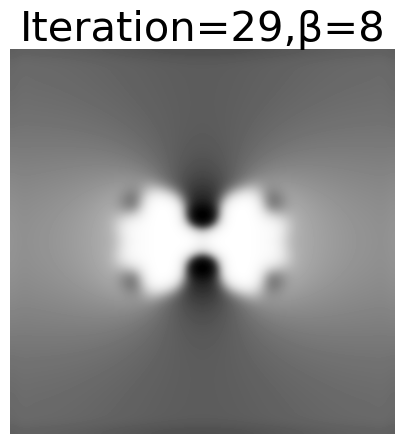

[0.56466913 0.53649862 0.53840192 ... 0.53840192 0.53649862 0.56466913]
2
0.5
8
[0.56130909 0.53465374 0.53639062 ... 0.53639062 0.53465374 0.56130909]


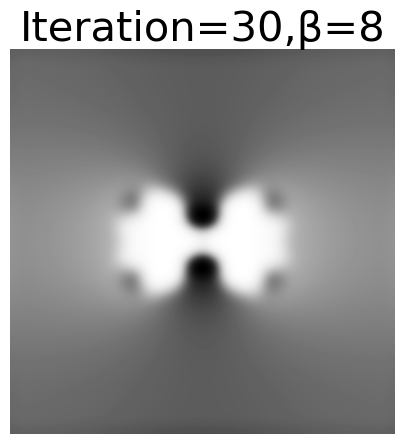

[0.564669   0.53649854 0.53840184 ... 0.53840184 0.53649854 0.564669  ]
2
0.5
16
[0.564669   0.53649854 0.53840184 ... 0.53840184 0.53649854 0.564669  ]


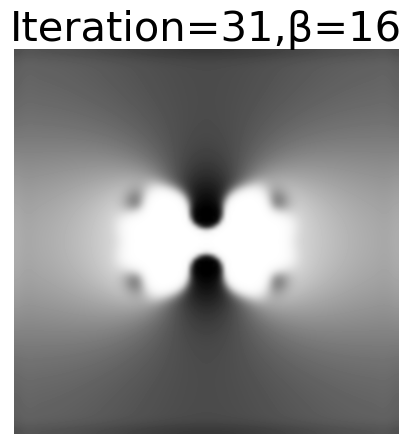

[0.57951435 0.54532871 0.54841042 ... 0.54841042 0.54532871 0.57951435]
2
0.5
16
[0.564669   0.53649854 0.53840184 ... 0.53840184 0.53649854 0.564669  ]


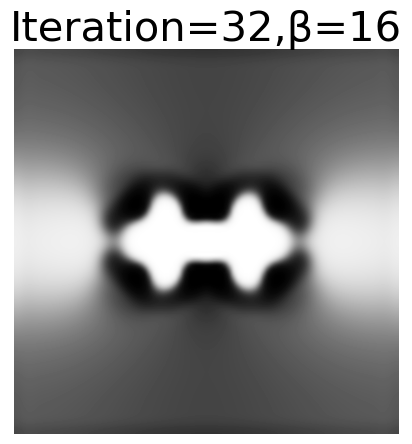

[0.56661492 0.53763151 0.53969138 ... 0.53969138 0.53763151 0.56661492]
2
0.5
16
[0.564669   0.53649854 0.53840184 ... 0.53840184 0.53649854 0.564669  ]


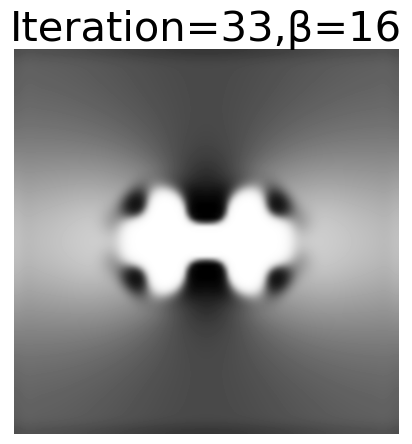

[0.56508378 0.53673942 0.53867614 ... 0.53867614 0.53673942 0.56508378]
2
0.5
16
[0.564669   0.53649854 0.53840184 ... 0.53840184 0.53649854 0.564669  ]


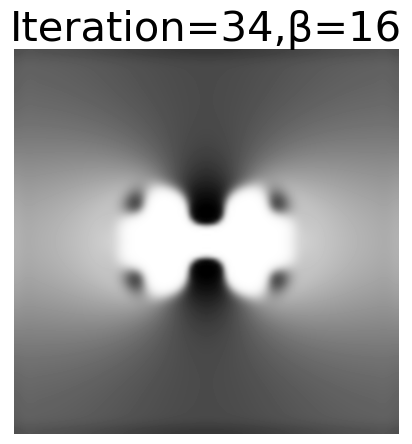

[0.564794   0.5365711  0.53848447 ... 0.53848447 0.5365711  0.564794  ]
2
0.5
16
[0.564669   0.53649854 0.53840184 ... 0.53840184 0.53649854 0.564669  ]


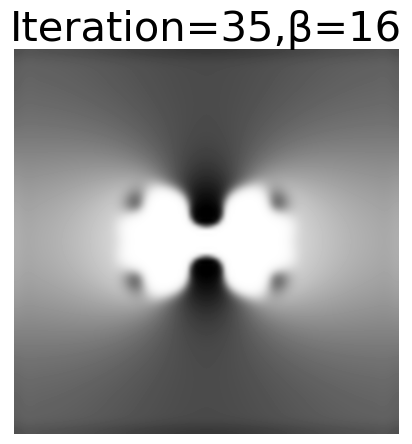

[0.56471204 0.53652352 0.53843029 ... 0.53843029 0.53652352 0.56471204]
2
0.5
16
[0.564669   0.53649854 0.53840184 ... 0.53840184 0.53649854 0.564669  ]


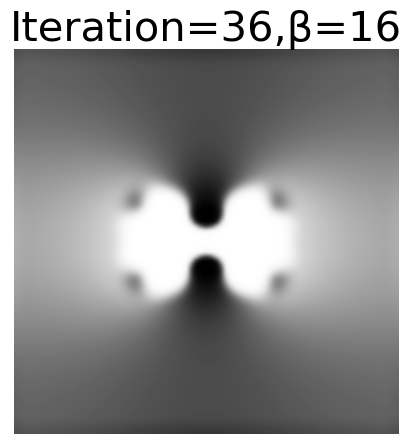

[0.56468287 0.53650659 0.53841101 ... 0.53841101 0.53650659 0.56468287]
2
0.5
16
[0.564669   0.53649854 0.53840184 ... 0.53840184 0.53649854 0.564669  ]


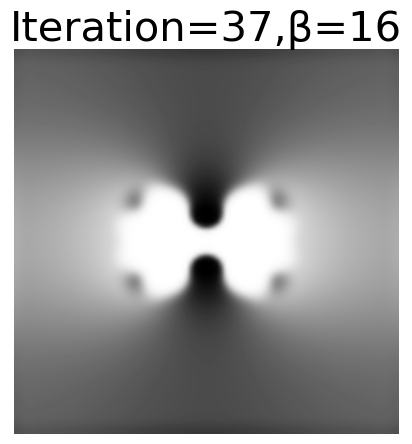

[0.56486826 0.53661416 0.53853343 ... 0.53853343 0.53661416 0.56486826]
2
0.5
16
[0.564669   0.53649854 0.53840184 ... 0.53840184 0.53649854 0.564669  ]


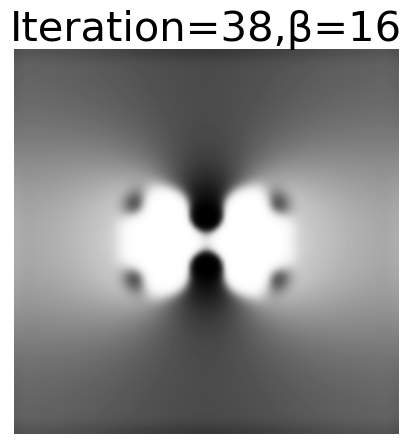

[0.56493409 0.53665236 0.53857692 ... 0.53857692 0.53665236 0.56493409]
2
0.5
16
[0.564669   0.53649854 0.53840184 ... 0.53840184 0.53649854 0.564669  ]


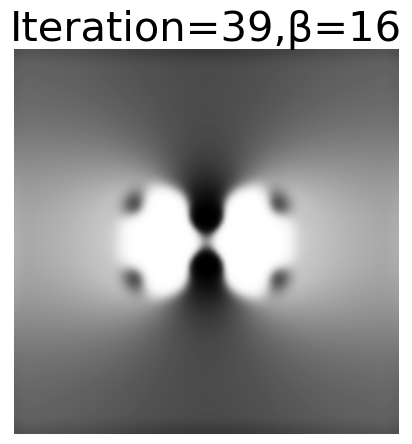

[0.56489009 0.53662682 0.53854785 ... 0.53854785 0.53662682 0.56489009]
2
0.5
16
[0.564669   0.53649854 0.53840184 ... 0.53840184 0.53649854 0.564669  ]


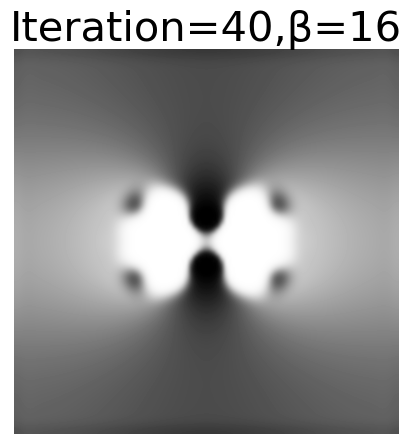

[0.56487672 0.53661907 0.53853902 ... 0.53853902 0.53661907 0.56487672]
2
0.5
16
[0.564669   0.53649854 0.53840184 ... 0.53840184 0.53649854 0.564669  ]


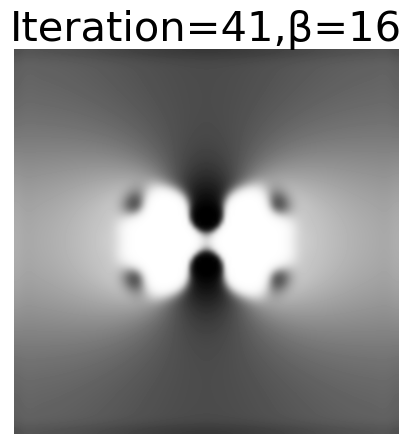

[0.56487178 0.5366162  0.53853576 ... 0.53853576 0.5366162  0.56487178]
2
0.5
16
[0.564669   0.53649854 0.53840184 ... 0.53840184 0.53649854 0.564669  ]


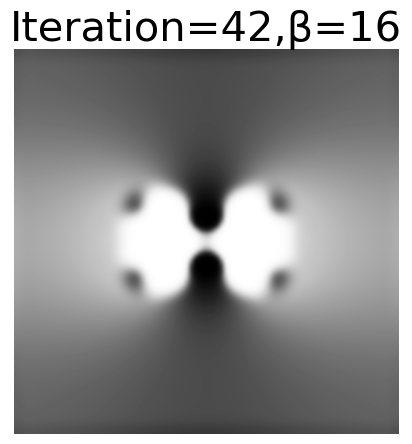

[0.56486959 0.53661493 0.53853431 ... 0.53853431 0.53661493 0.56486959]
2
0.5
16
[0.564669   0.53649854 0.53840184 ... 0.53840184 0.53649854 0.564669  ]


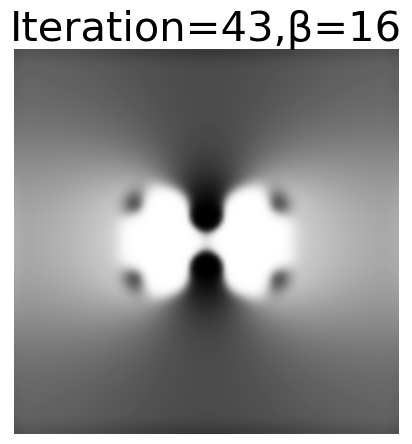

[0.5648688  0.53661447 0.53853379 ... 0.53853379 0.53661447 0.5648688 ]
2
0.5
16
[0.564669   0.53649854 0.53840184 ... 0.53840184 0.53649854 0.564669  ]


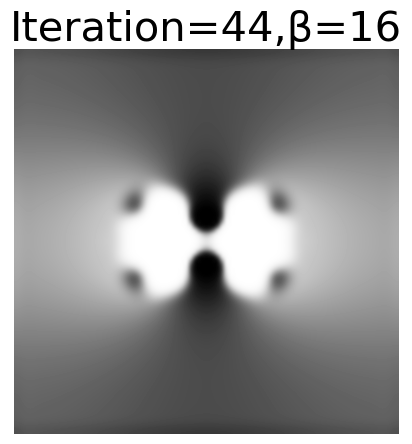

[0.56486848 0.53661429 0.53853358 ... 0.53853358 0.53661429 0.56486848]
2
0.5
16
[0.564669   0.53649854 0.53840184 ... 0.53840184 0.53649854 0.564669  ]


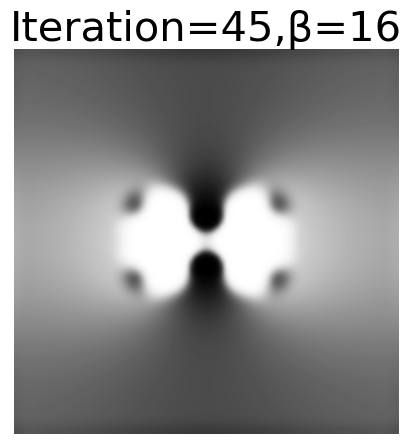

[0.56486826 0.53661416 0.53853343 ... 0.53853343 0.53661416 0.56486826]
2
0.5
32
[0.56486826 0.53661416 0.53853343 ... 0.53853343 0.53661416 0.56486826]


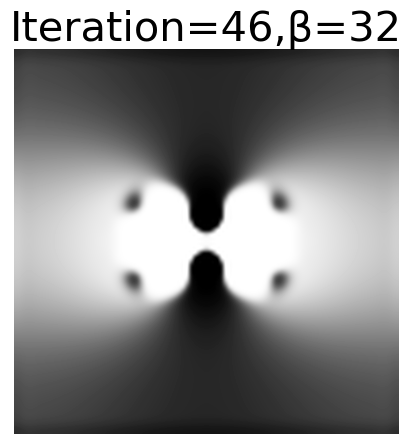

[0.5834975  0.54916967 0.5539309  ... 0.5539309  0.54916967 0.5834975 ]
2
0.5
32
[0.56486826 0.53661416 0.53853343 ... 0.53853343 0.53661416 0.56486826]


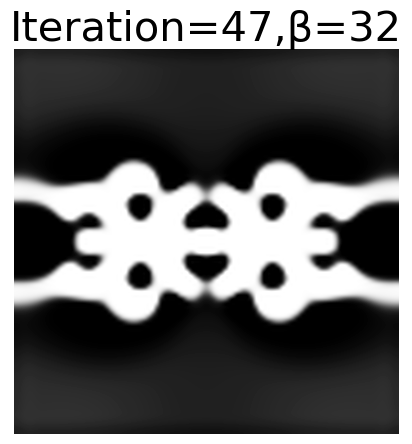

[0.56686217 0.53792829 0.54016192 ... 0.54016192 0.53792829 0.56686217]
2
0.5
32
[0.56486826 0.53661416 0.53853343 ... 0.53853343 0.53661416 0.56486826]


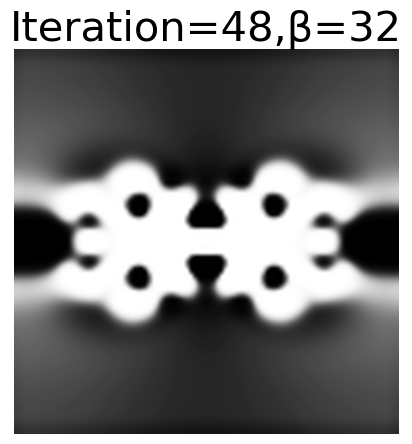

[0.56526969 0.53687816 0.53886091 ... 0.53886091 0.53687816 0.56526969]
2
0.5
32
[0.56486826 0.53661416 0.53853343 ... 0.53853343 0.53661416 0.56486826]


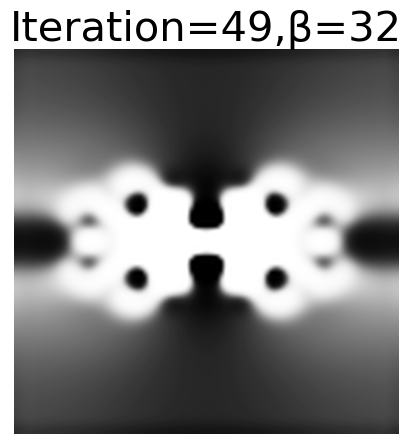

[0.56498975 0.53669402 0.53863252 ... 0.53863252 0.53669402 0.56498975]
2
0.5
32
[0.56486826 0.53661416 0.53853343 ... 0.53853343 0.53661416 0.56486826]


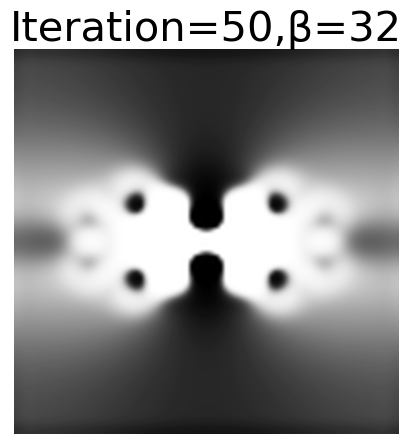

[0.56491206 0.53664295 0.53856915 ... 0.53856915 0.53664295 0.56491206]
2
0.5
32
[0.56486826 0.53661416 0.53853343 ... 0.53853343 0.53661416 0.56486826]


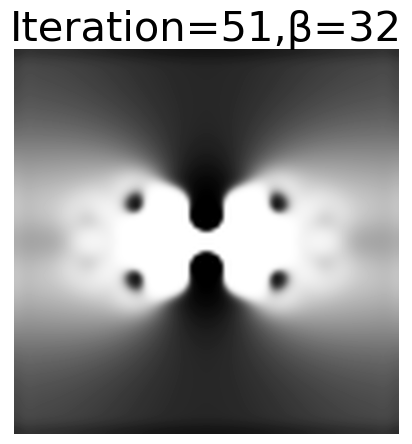

[0.56488505 0.53662519 0.53854712 ... 0.53854712 0.53662519 0.56488505]
2
0.5
32
[0.56486826 0.53661416 0.53853343 ... 0.53853343 0.53661416 0.56486826]


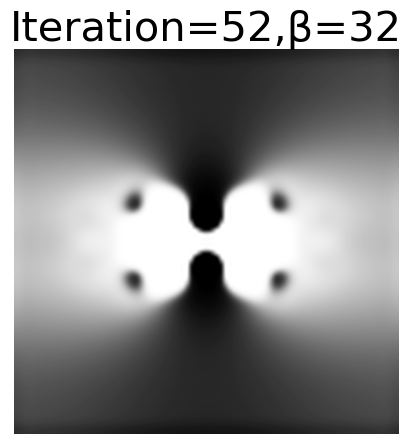

[0.56487435 0.53661816 0.5385384  ... 0.5385384  0.53661816 0.56487435]
2
0.5
32
[0.56486826 0.53661416 0.53853343 ... 0.53853343 0.53661416 0.56486826]


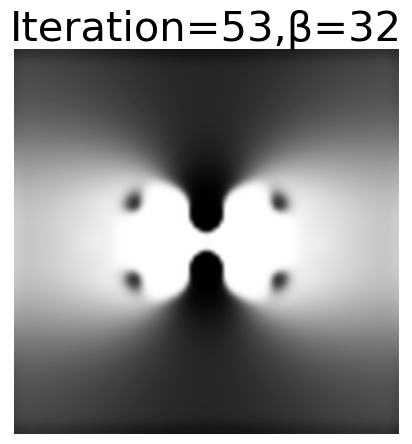

[0.56487995 0.53662184 0.53854295 ... 0.53854295 0.53662184 0.56487995]
2
0.5
32
[0.56486826 0.53661416 0.53853343 ... 0.53853343 0.53661416 0.56486826]


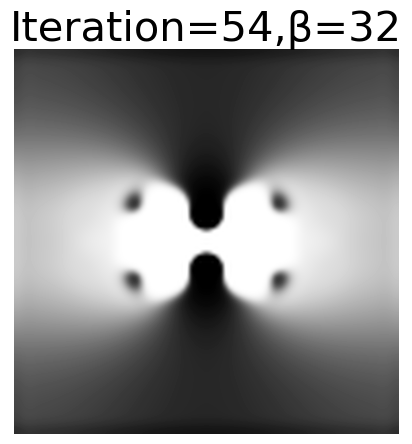

[0.56487643 0.53661953 0.53854009 ... 0.53854009 0.53661953 0.56487643]
2
0.5
32
[0.56486826 0.53661416 0.53853343 ... 0.53853343 0.53661416 0.56486826]


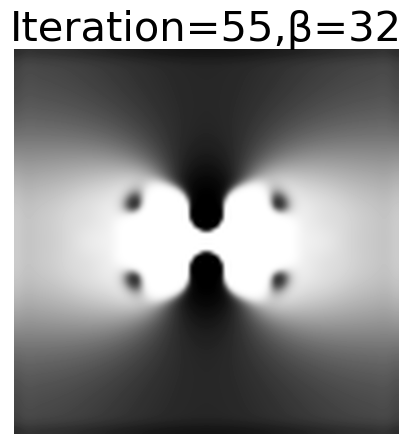

[0.56487519 0.53661871 0.53853908 ... 0.53853908 0.53661871 0.56487519]
2
0.5
32
[0.56486826 0.53661416 0.53853343 ... 0.53853343 0.53661416 0.56486826]


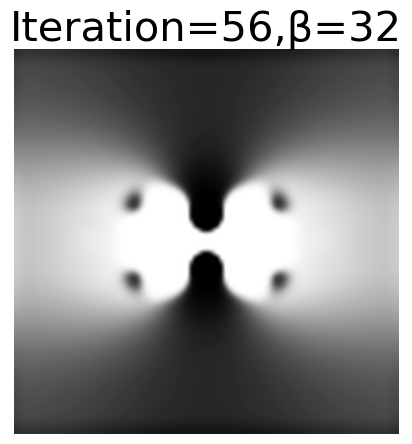

[0.56487468 0.53661838 0.53853867 ... 0.53853867 0.53661838 0.56487468]
2
0.5
32
[0.56486826 0.53661416 0.53853343 ... 0.53853343 0.53661416 0.56486826]


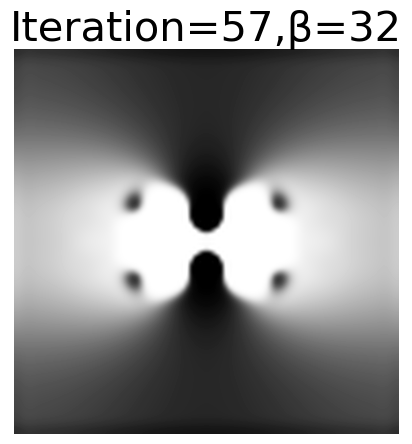

[0.56487447 0.53661824 0.5385385  ... 0.5385385  0.53661824 0.56487447]
2
0.5
32
[0.56486826 0.53661416 0.53853343 ... 0.53853343 0.53661416 0.56486826]


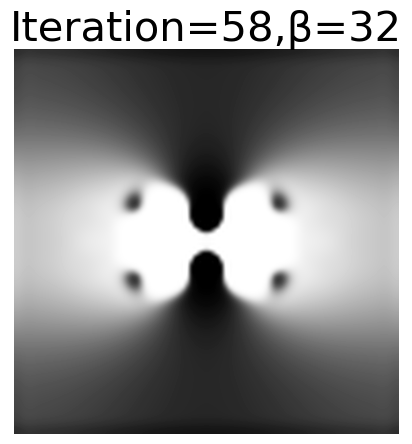

[0.56487439 0.53661819 0.53853843 ... 0.53853843 0.53661819 0.56487439]
2
0.5
32
[0.56486826 0.53661416 0.53853343 ... 0.53853343 0.53661416 0.56486826]


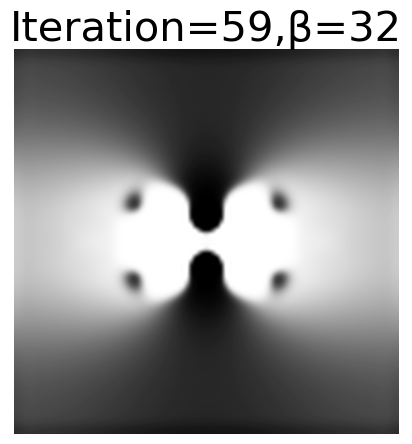

[0.56487437 0.53661817 0.53853841 ... 0.53853841 0.53661817 0.56487437]
2
0.5
32
[0.56486826 0.53661416 0.53853343 ... 0.53853343 0.53661416 0.56486826]


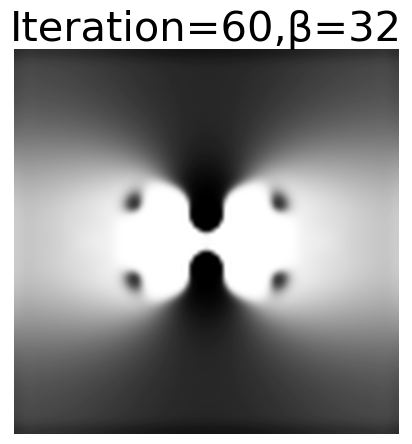

[0.56487435 0.53661816 0.5385384  ... 0.5385384  0.53661816 0.56487435]
2
0.5
64
[0.56487435 0.53661816 0.5385384  ... 0.5385384  0.53661816 0.56487435]


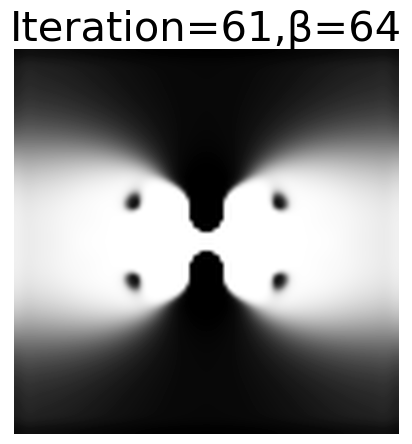

[0.56578324 0.53739165 0.5396525  ... 0.5396525  0.53739165 0.56578324]
2
0.5
64
[0.56487435 0.53661816 0.5385384  ... 0.5385384  0.53661816 0.56487435]


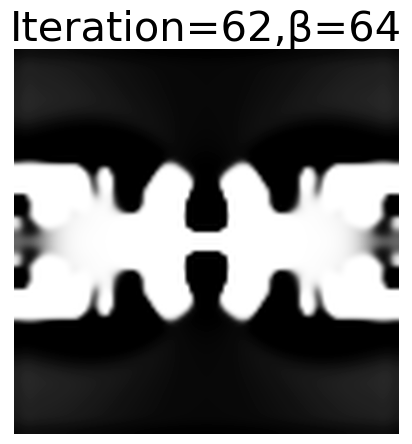

[0.56497791 0.53670625 0.53866543 ... 0.53866543 0.53670625 0.56497791]
2
0.5
64
[0.56487435 0.53661816 0.5385384  ... 0.5385384  0.53661816 0.56487435]


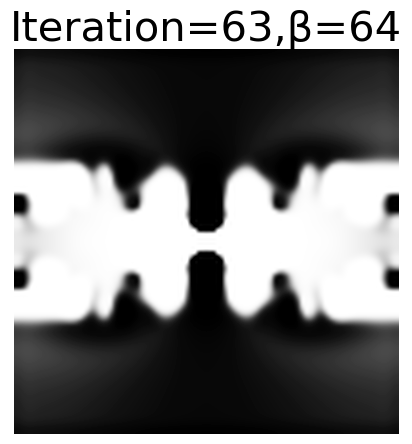

[0.56500261 0.53672728 0.53869579 ... 0.53869579 0.53672728 0.56500261]
2
0.5
64
[0.56487435 0.53661816 0.5385384  ... 0.5385384  0.53661816 0.56487435]


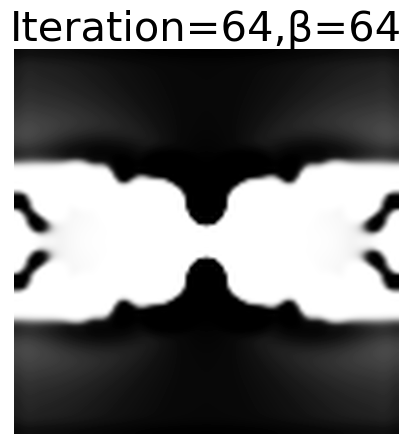

[0.5649838  0.53671127 0.53867267 ... 0.53867267 0.53671127 0.5649838 ]
2
0.5
64
[0.56487435 0.53661816 0.5385384  ... 0.5385384  0.53661816 0.56487435]


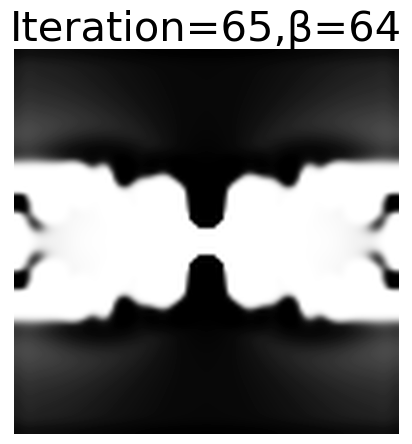

[0.5649799  0.53670794 0.53866787 ... 0.53866787 0.53670794 0.5649799 ]
2
0.5
64
[0.56487435 0.53661816 0.5385384  ... 0.5385384  0.53661816 0.56487435]


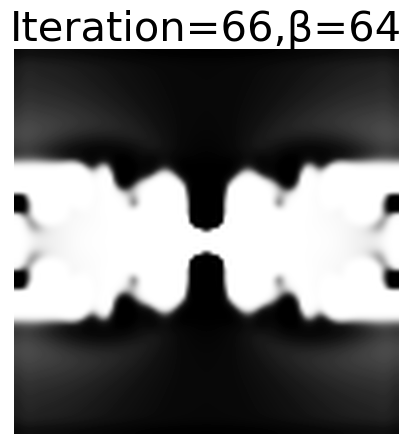

[0.56498052 0.53670847 0.53866862 ... 0.53866862 0.53670847 0.56498052]
2
0.5
64
[0.56487435 0.53661816 0.5385384  ... 0.5385384  0.53661816 0.56487435]


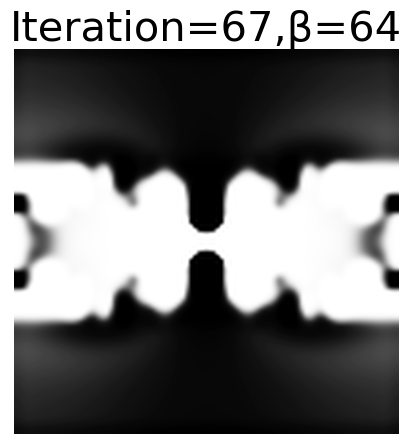

[0.56498014 0.53670815 0.53866816 ... 0.53866816 0.53670815 0.56498014]
2
0.5
64
[0.56487435 0.53661816 0.5385384  ... 0.5385384  0.53661816 0.56487435]


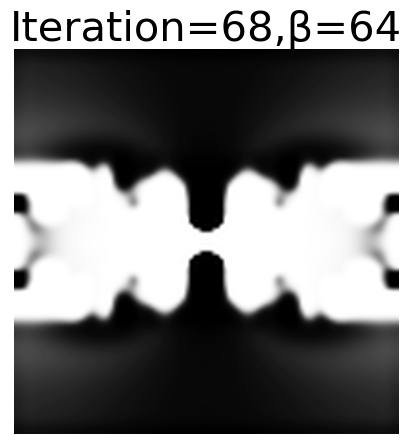

[0.56498    0.53670803 0.53866799 ... 0.53866799 0.53670803 0.56498   ]
2
0.5
64
[0.56487435 0.53661816 0.5385384  ... 0.5385384  0.53661816 0.56487435]


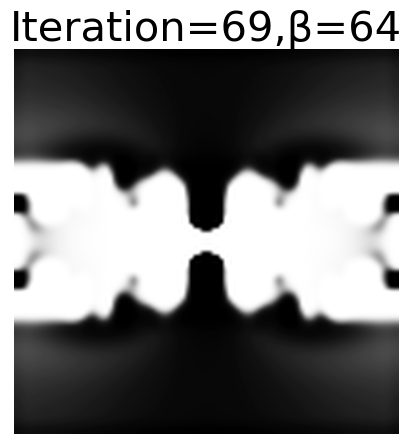

[0.56497994 0.53670798 0.53866793 ... 0.53866793 0.53670798 0.56497994]
2
0.5
64
[0.56487435 0.53661816 0.5385384  ... 0.5385384  0.53661816 0.56487435]


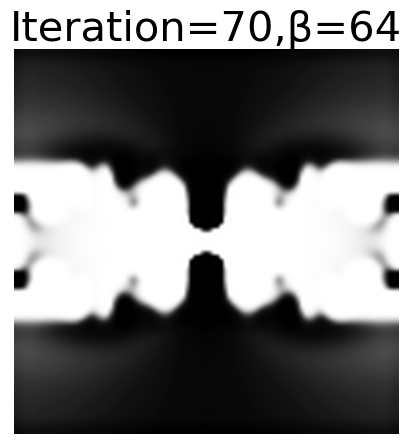

[0.56497992 0.53670796 0.5386679  ... 0.5386679  0.53670796 0.56497992]
2
0.5
64
[0.56487435 0.53661816 0.5385384  ... 0.5385384  0.53661816 0.56487435]


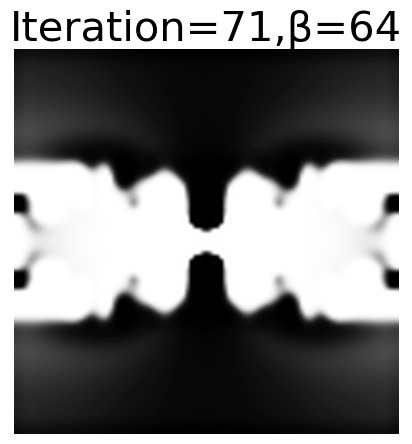

[0.5649799  0.53670795 0.53866788 ... 0.53866788 0.53670795 0.5649799 ]
2
0.5
64
[0.56487435 0.53661816 0.5385384  ... 0.5385384  0.53661816 0.56487435]


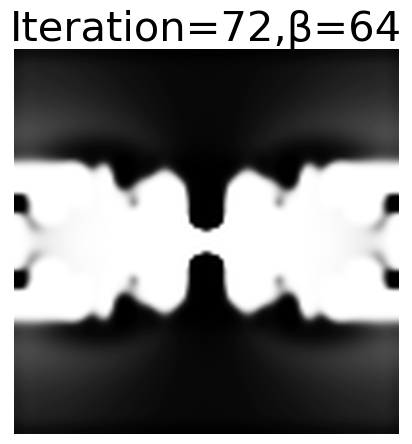

[0.5649799  0.53670795 0.53866788 ... 0.53866788 0.53670795 0.5649799 ]
2
0.5
64
[0.56487435 0.53661816 0.5385384  ... 0.5385384  0.53661816 0.56487435]


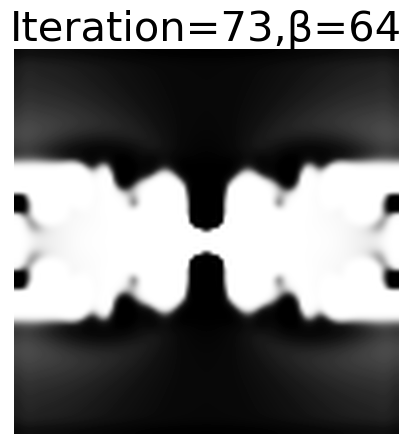

[0.5649799  0.53670794 0.53866788 ... 0.53866788 0.53670794 0.5649799 ]
2
0.5
64
[0.56487435 0.53661816 0.5385384  ... 0.5385384  0.53661816 0.56487435]


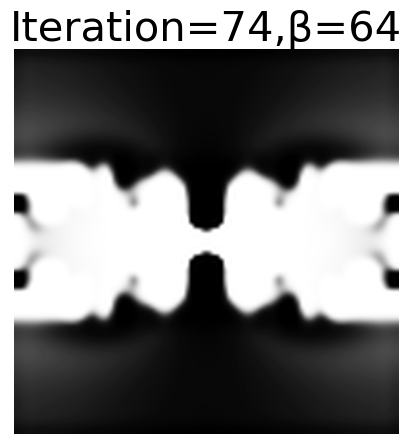

[0.5649799  0.53670794 0.53866787 ... 0.53866787 0.53670794 0.5649799 ]
2
0.5
64
[0.56487435 0.53661816 0.5385384  ... 0.5385384  0.53661816 0.56487435]


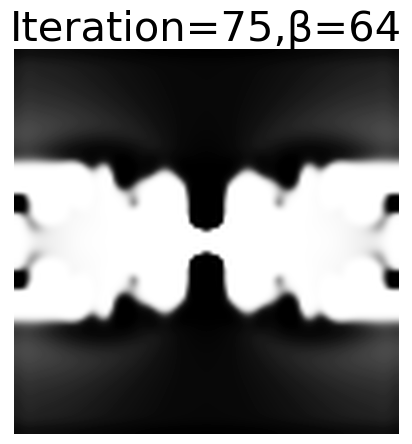

[0.5649799  0.53670794 0.53866787 ... 0.53866787 0.53670794 0.5649799 ]
2
0.5
128
[0.5649799  0.53670794 0.53866787 ... 0.53866787 0.53670794 0.5649799 ]


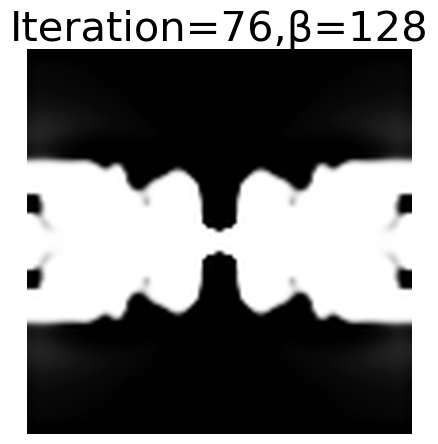

[0.56499547 0.53672959 0.53870713 ... 0.53870713 0.53672959 0.56499547]
2
0.5
128
[0.5649799  0.53670794 0.53866787 ... 0.53866787 0.53670794 0.5649799 ]


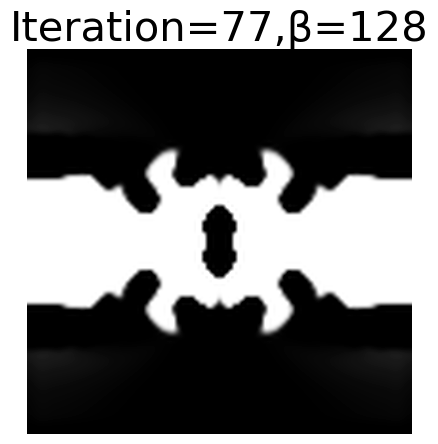

[0.56498145 0.53671011 0.5386718  ... 0.5386718  0.53671011 0.56498145]
2
0.5
128
[0.5649799  0.53670794 0.53866787 ... 0.53866787 0.53670794 0.5649799 ]


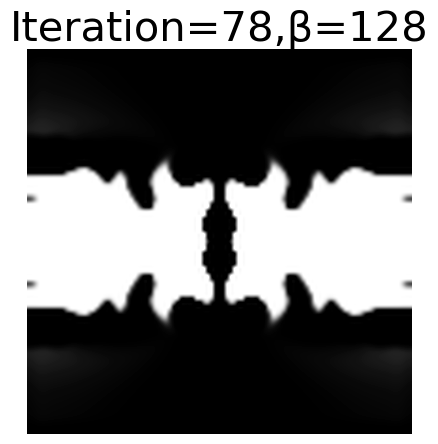

[0.56498006 0.53670818 0.53866829 ... 0.53866829 0.53670818 0.56498006]
2
0.5
128
[0.5649799  0.53670794 0.53866787 ... 0.53866787 0.53670794 0.5649799 ]


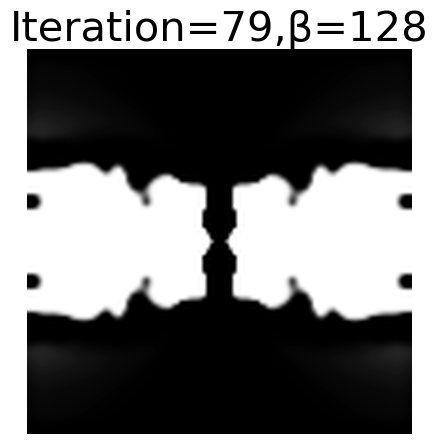

[0.56497993 0.53670799 0.53866796 ... 0.53866796 0.53670799 0.56497993]
2
0.5
128
[0.5649799  0.53670794 0.53866787 ... 0.53866787 0.53670794 0.5649799 ]


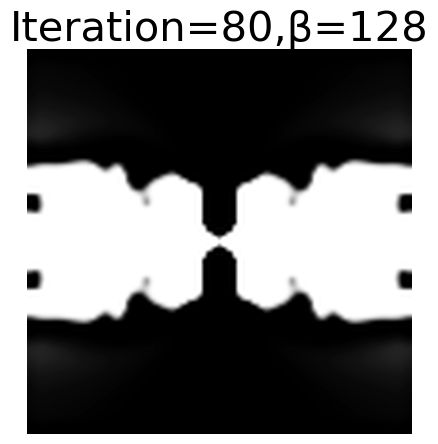

[0.56497996 0.53670803 0.53866803 ... 0.53866803 0.53670803 0.56497996]
2
0.5
128
[0.5649799  0.53670794 0.53866787 ... 0.53866787 0.53670794 0.5649799 ]


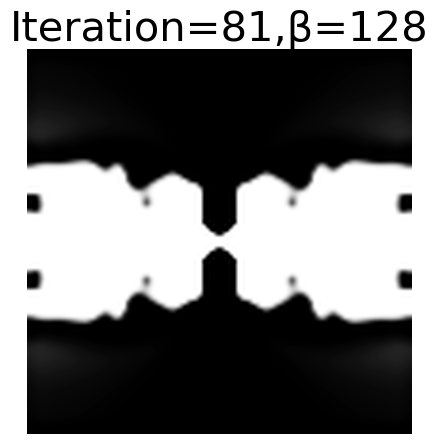

[0.56497996 0.53670803 0.53866804 ... 0.53866804 0.53670803 0.56497996]
2
0.5
128
[0.5649799  0.53670794 0.53866787 ... 0.53866787 0.53670794 0.5649799 ]


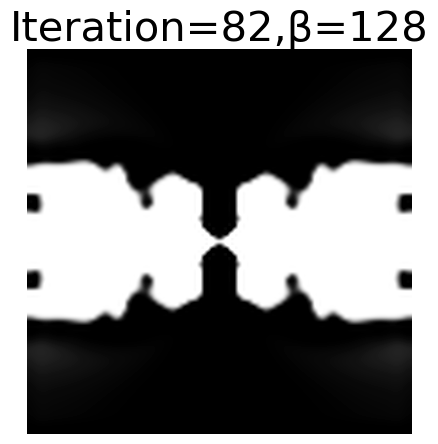

[0.56497996 0.53670803 0.53866803 ... 0.53866803 0.53670803 0.56497996]
2
0.5
128
[0.5649799  0.53670794 0.53866787 ... 0.53866787 0.53670794 0.5649799 ]


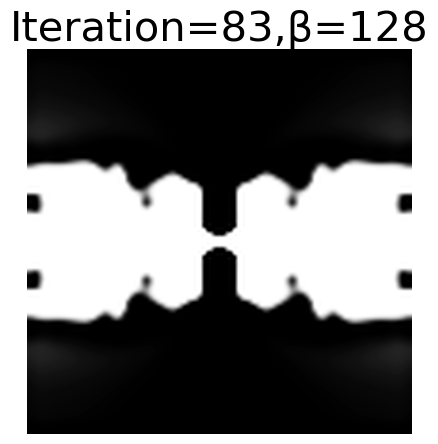

[0.56497996 0.53670803 0.53866803 ... 0.53866803 0.53670803 0.56497996]
2
0.5
128
[0.5649799  0.53670794 0.53866787 ... 0.53866787 0.53670794 0.5649799 ]


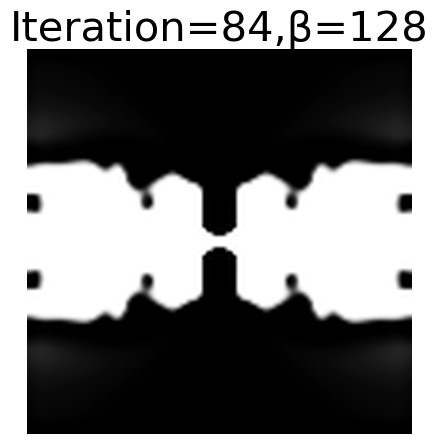

[0.56497996 0.53670803 0.53866803 ... 0.53866803 0.53670803 0.56497996]
2
0.5
128
[0.5649799  0.53670794 0.53866787 ... 0.53866787 0.53670794 0.5649799 ]


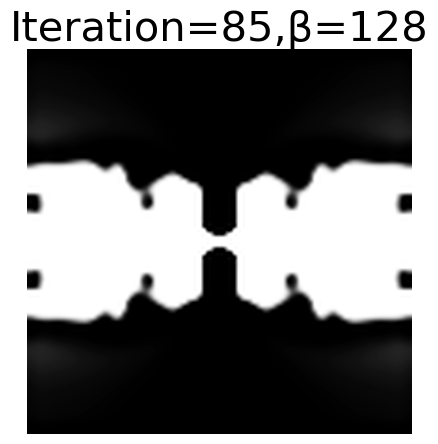

[0.56497996 0.53670803 0.53866803 ... 0.53866803 0.53670803 0.56497996]
2
0.5
128
[0.5649799  0.53670794 0.53866787 ... 0.53866787 0.53670794 0.5649799 ]


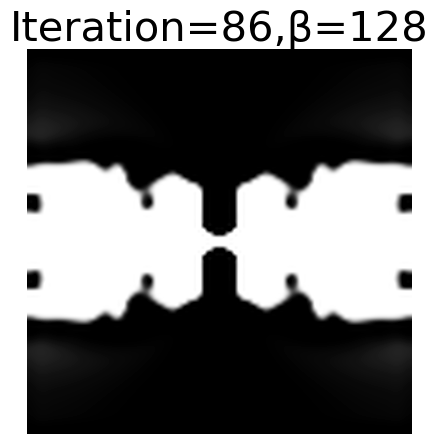

[0.56497996 0.53670803 0.53866802 ... 0.53866802 0.53670803 0.56497996]
2
0.5
128
[0.5649799  0.53670794 0.53866787 ... 0.53866787 0.53670794 0.5649799 ]


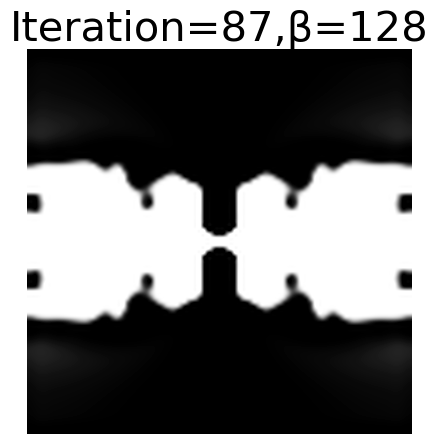

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
128
[0.5649799  0.53670794 0.53866787 ... 0.53866787 0.53670794 0.5649799 ]


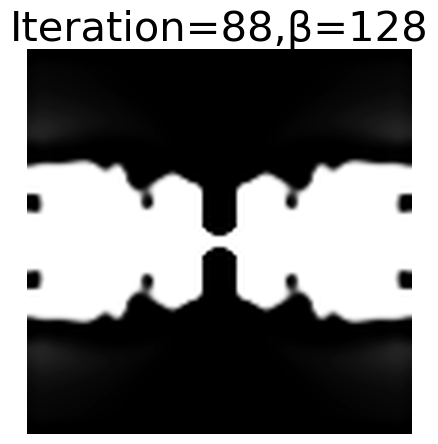

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
128
[0.5649799  0.53670794 0.53866787 ... 0.53866787 0.53670794 0.5649799 ]


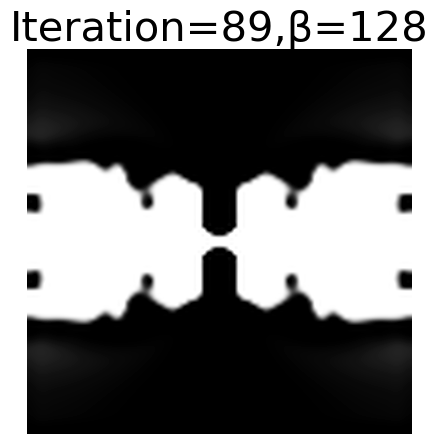

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
128
[0.5649799  0.53670794 0.53866787 ... 0.53866787 0.53670794 0.5649799 ]


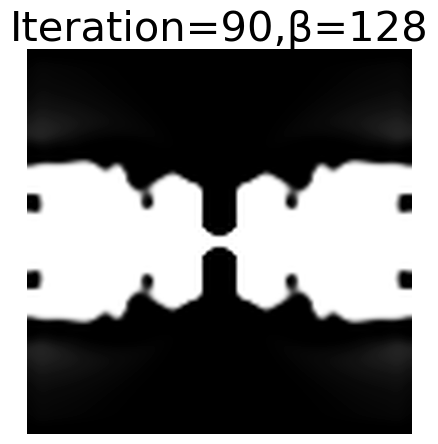

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
256
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


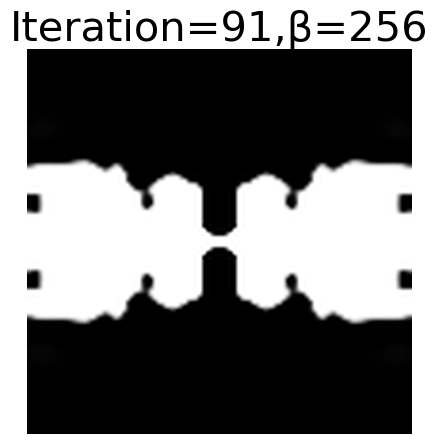

[0.56497995 0.53670801 0.538668   ... 0.538668   0.53670801 0.56497995]
2
0.5
256
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


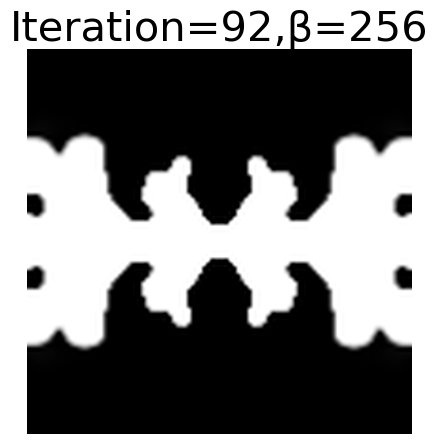

[0.56497995 0.53670802 0.53866801 ... 0.53866801 0.53670802 0.56497995]
2
0.5
256
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


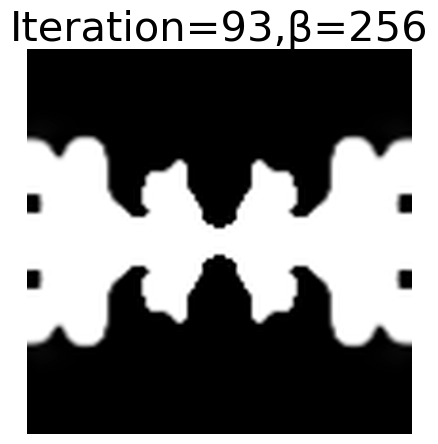

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
256
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


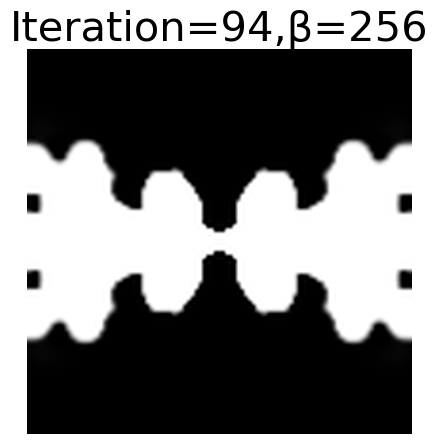

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
256
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


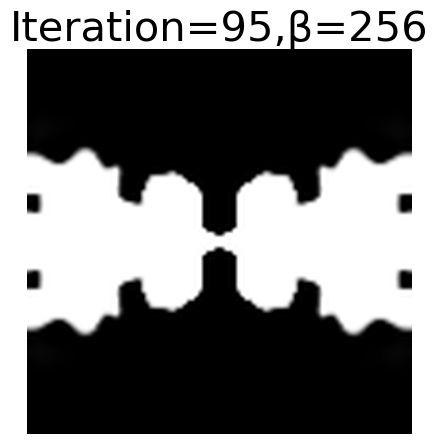

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
256
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


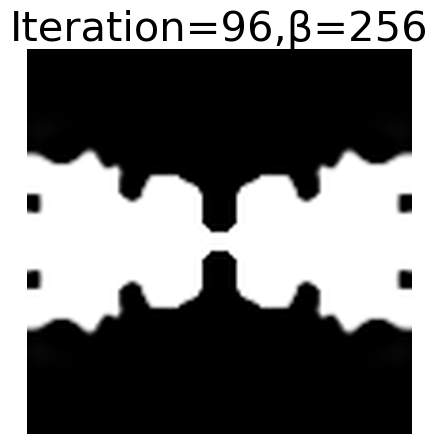

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
256
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


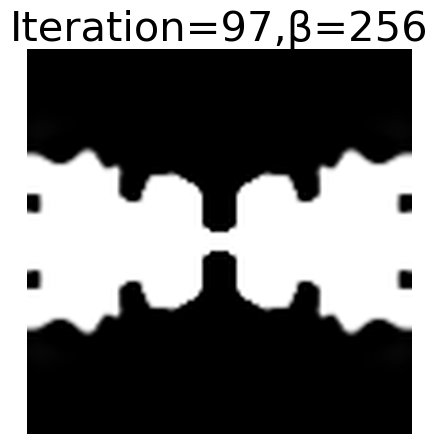

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
256
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


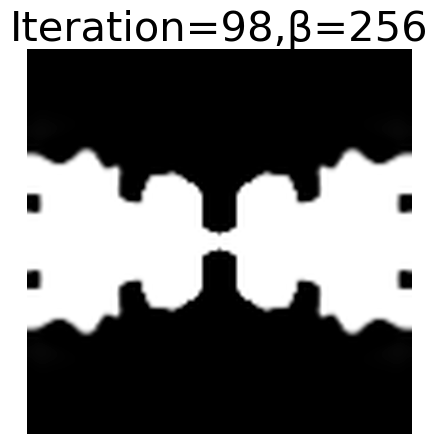

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
256
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


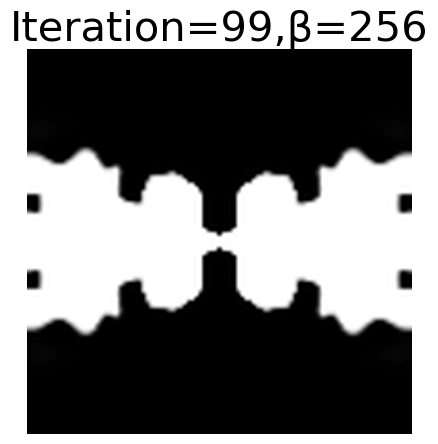

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
256
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


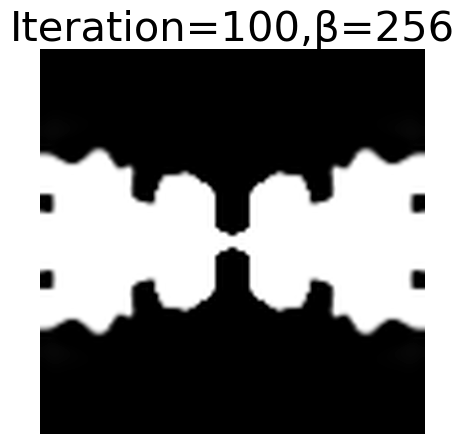

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
256
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


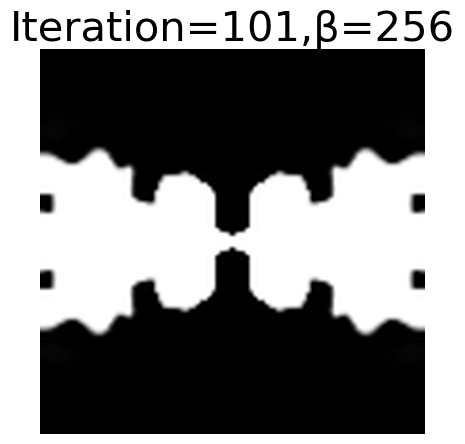

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
256
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


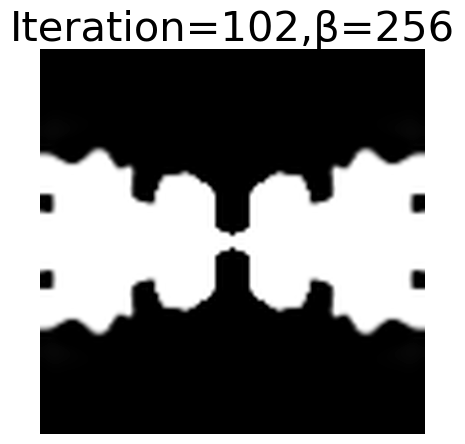

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
256
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


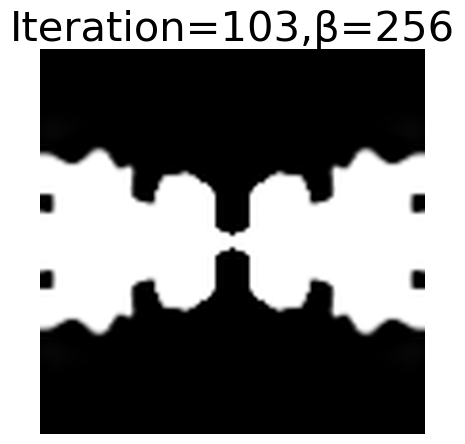

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
256
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


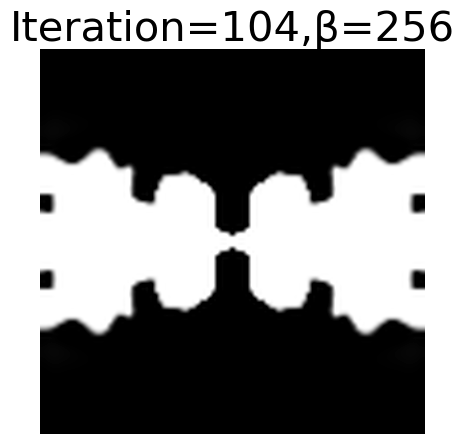

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
256
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


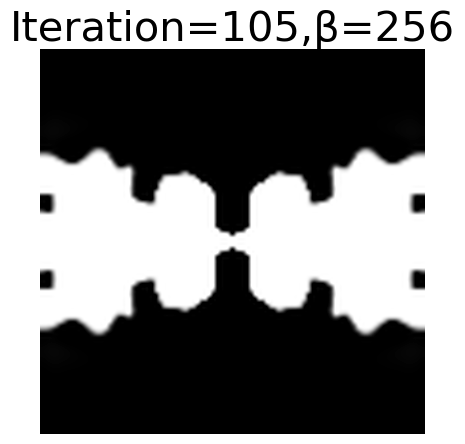

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
512
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


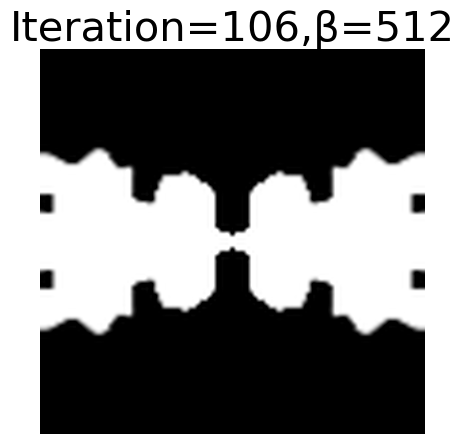

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
512
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


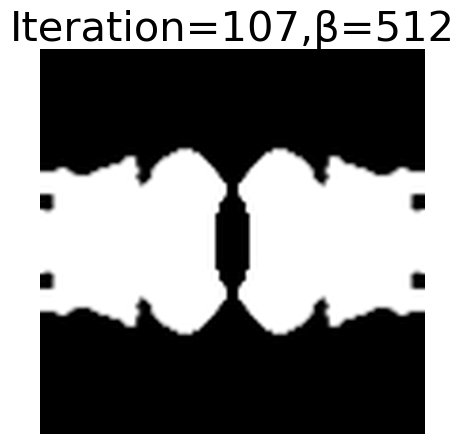

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
512
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


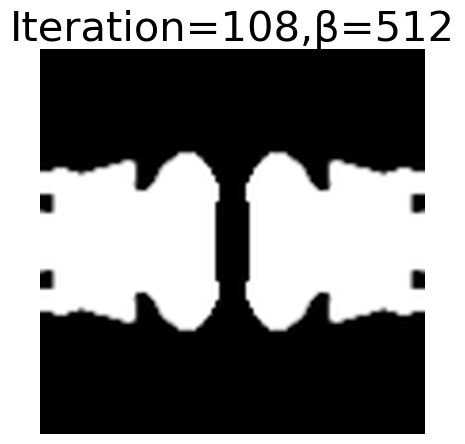

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
512
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


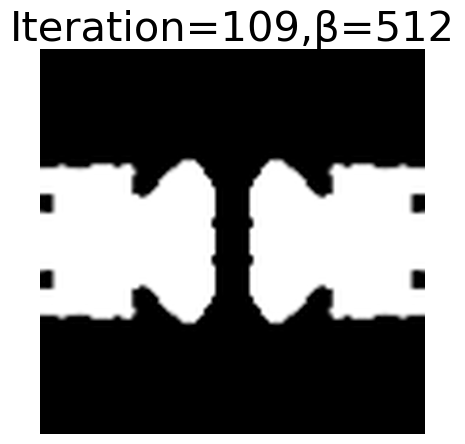

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
512
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


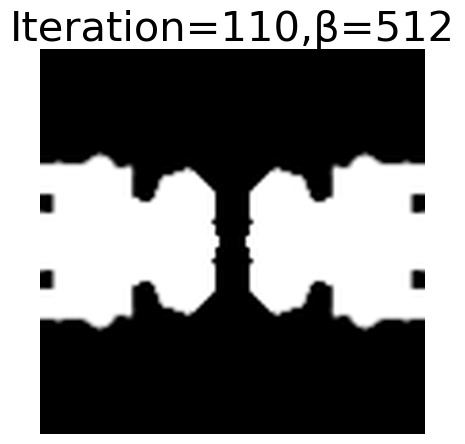

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
512
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


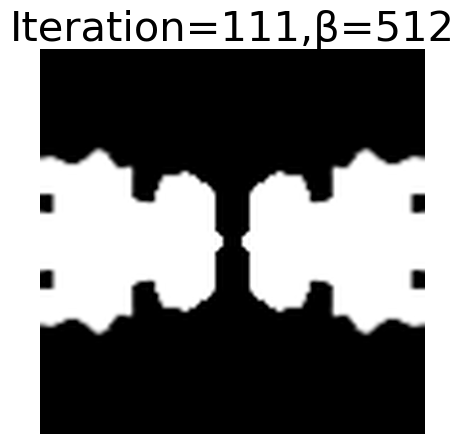

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
512
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


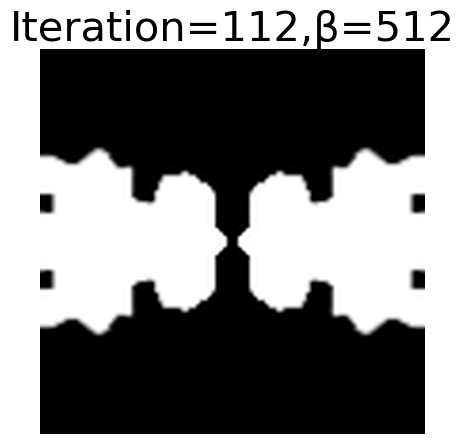

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
512
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


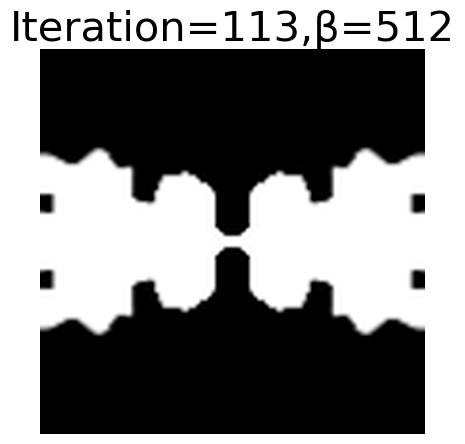

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
512
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


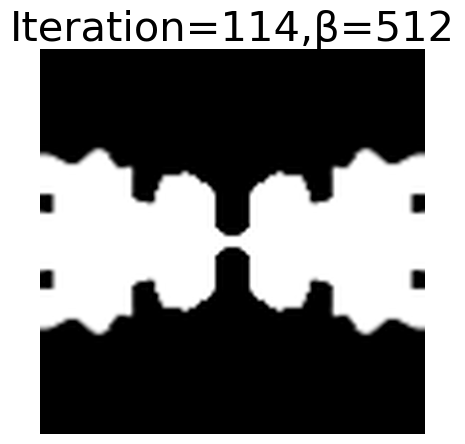

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
512
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


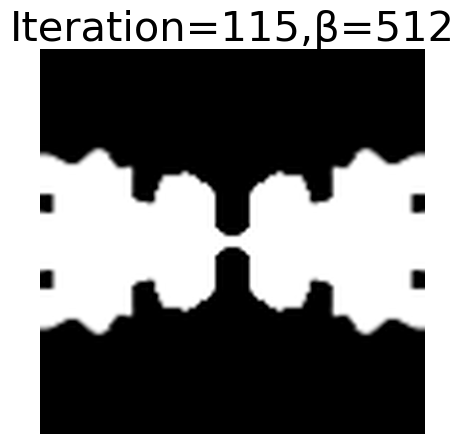

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
512
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


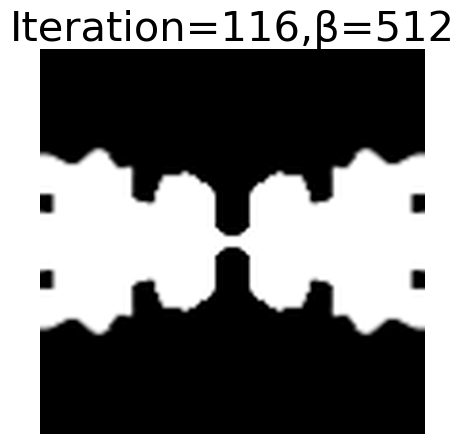

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
512
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


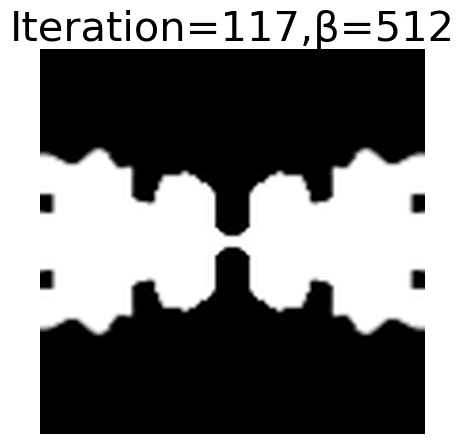

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
512
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


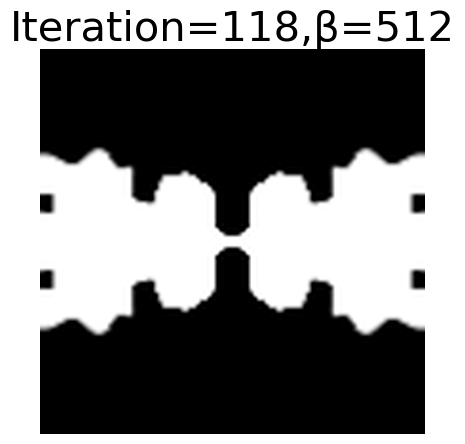

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
512
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


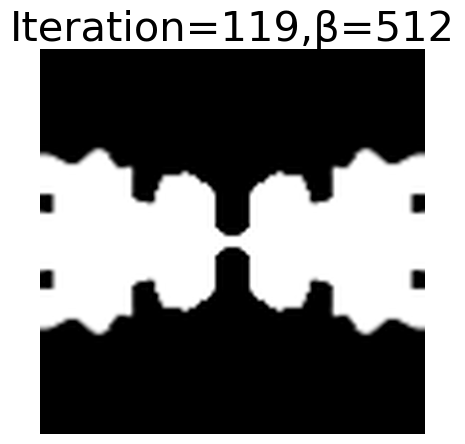

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
512
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


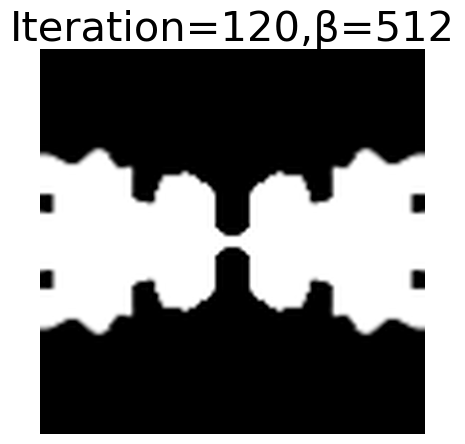

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
1024
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


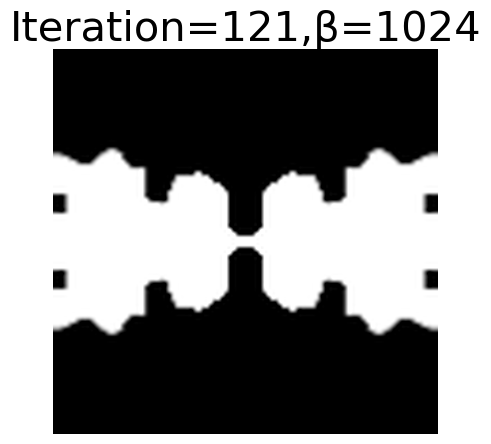

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
1024
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


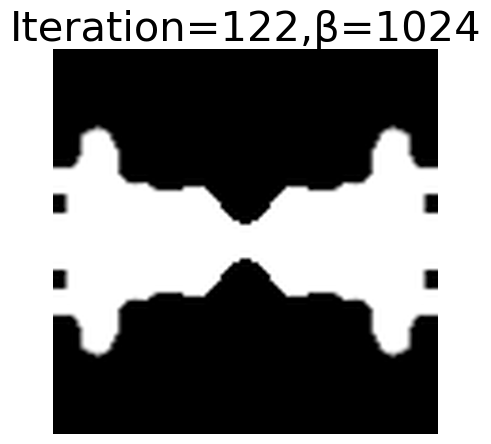

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
1024
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


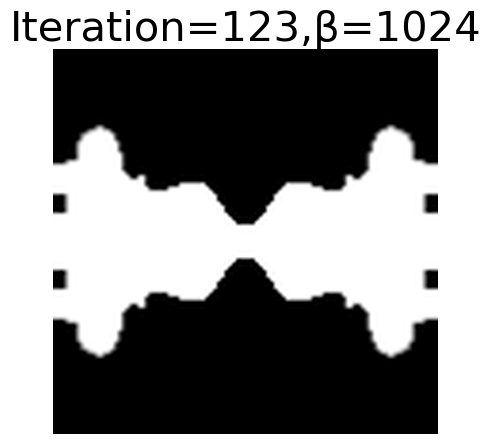

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
1024
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


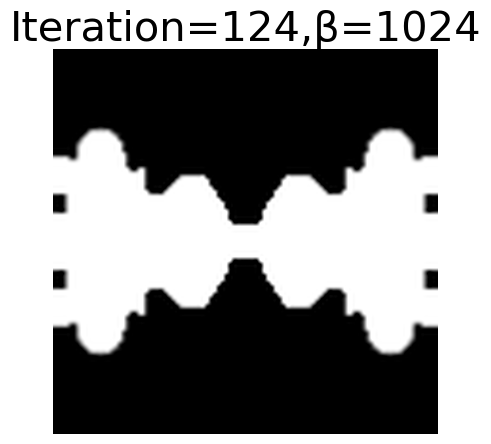

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
1024
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


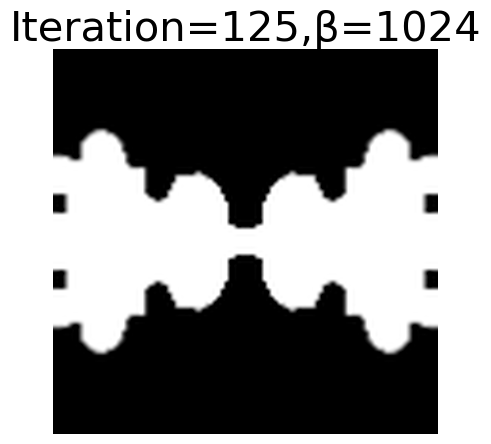

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
1024
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


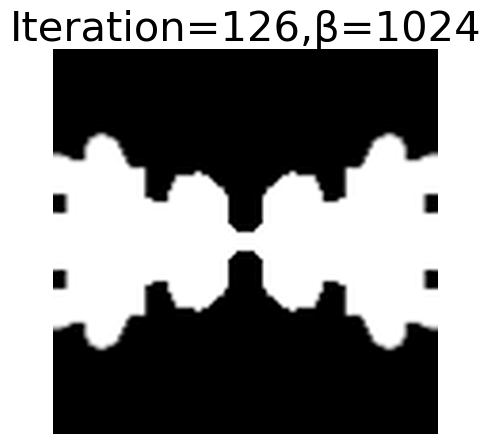

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
1024
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


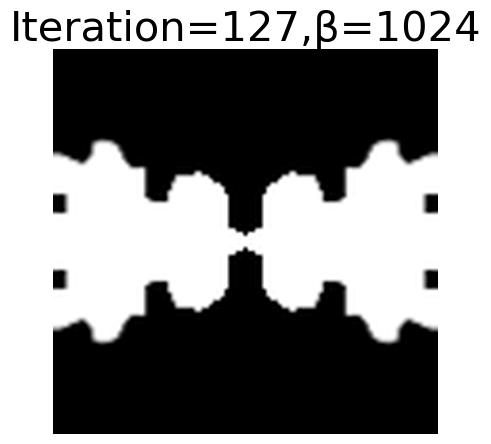

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
1024
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


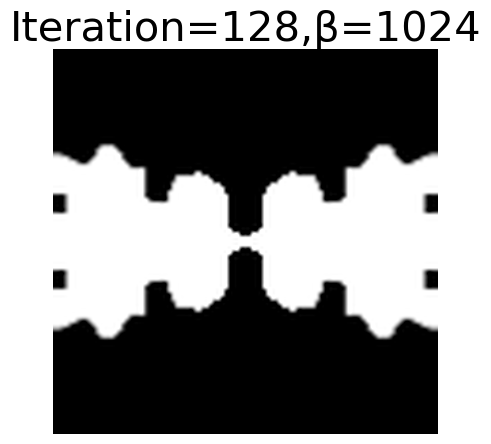

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
1024
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


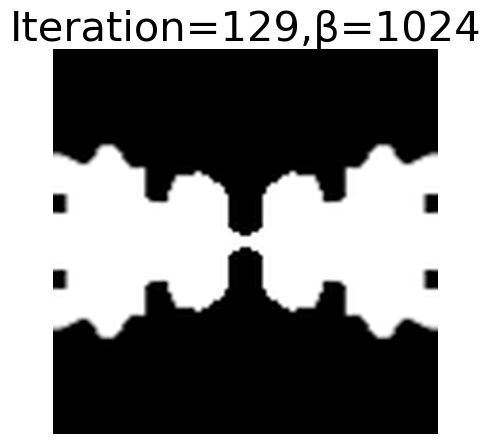

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
1024
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


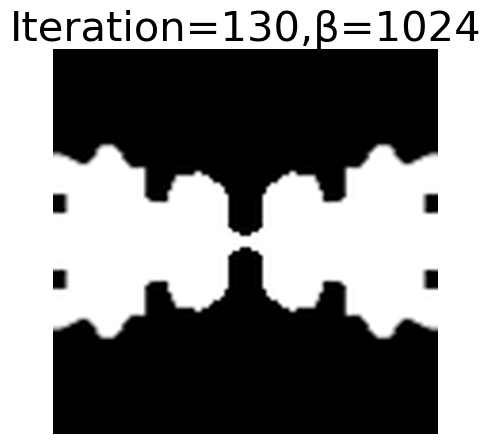

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
1024
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


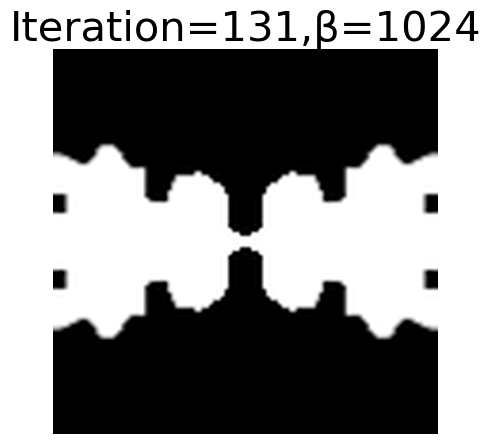

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
1024
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


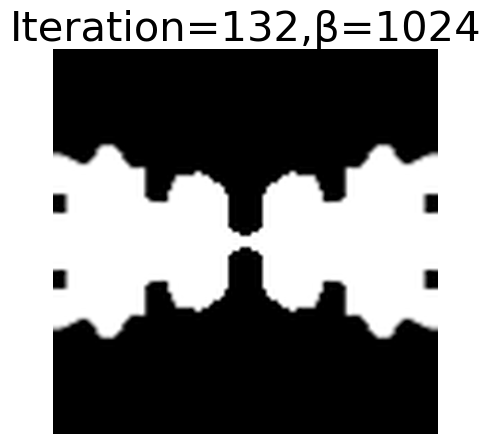

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
1024
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


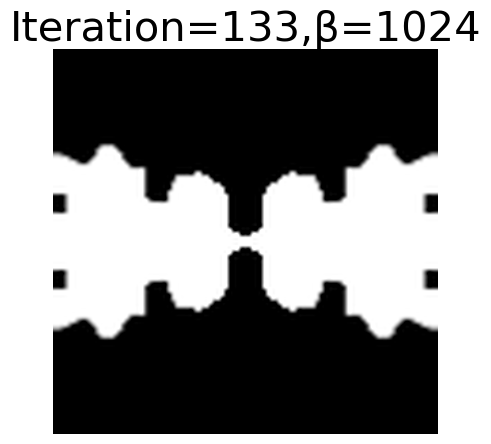

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
1024
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


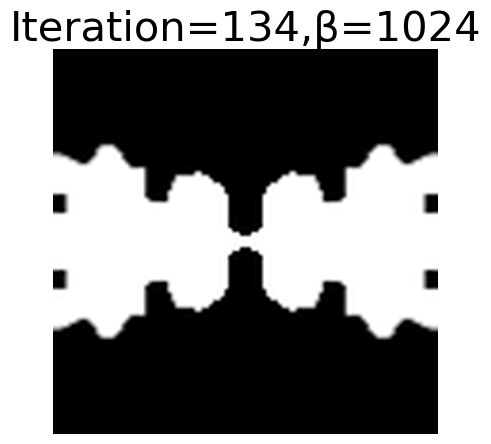

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
1024
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


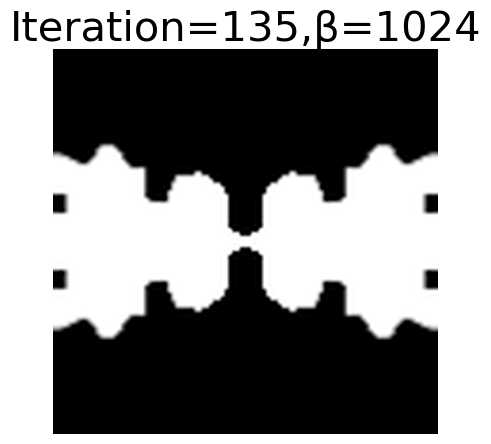

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
2048
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


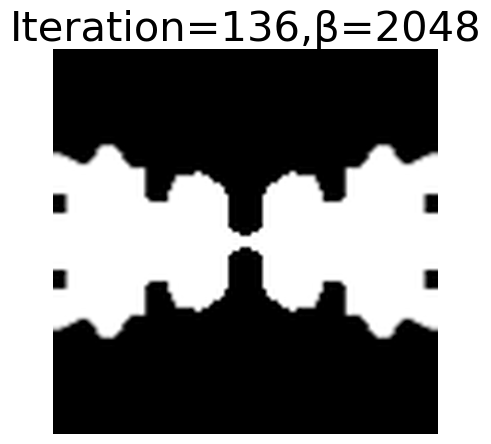

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
2048
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


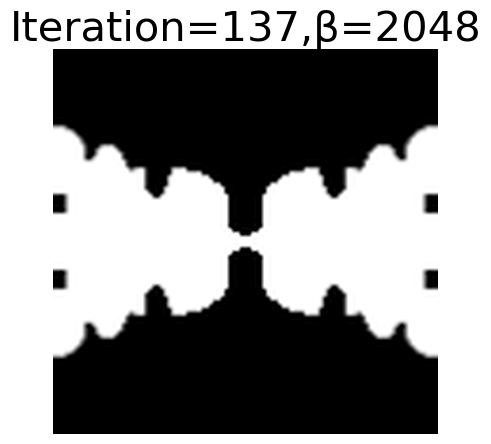

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
2048
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


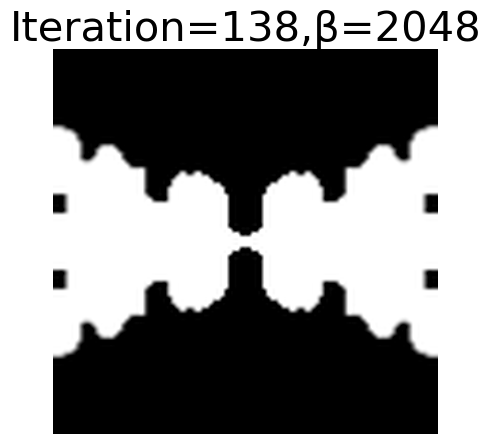

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
2048
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


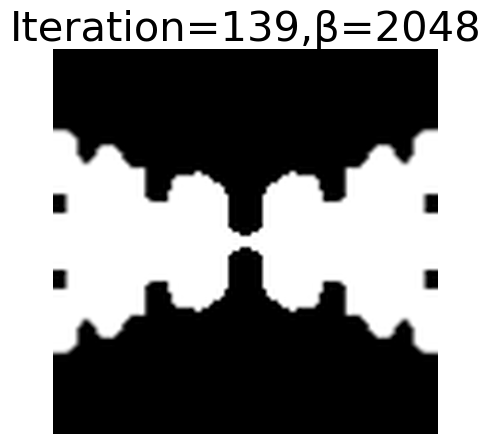

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
2048
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


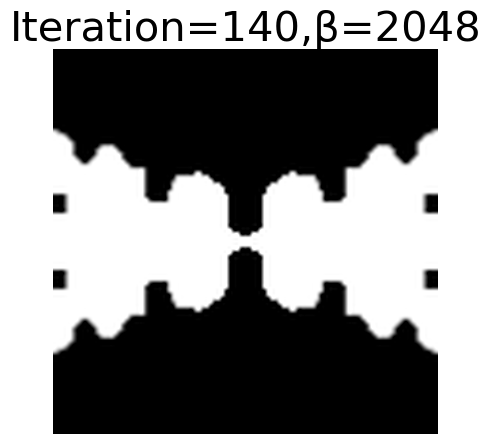

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
2048
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


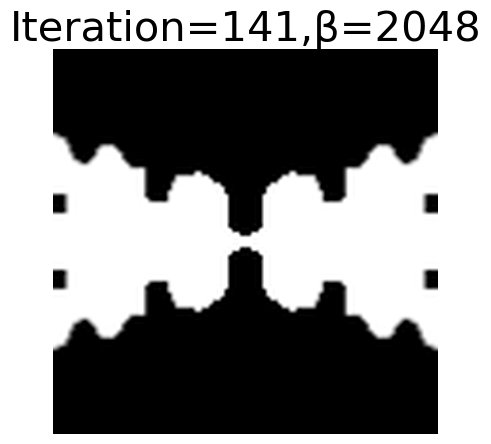

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
2048
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


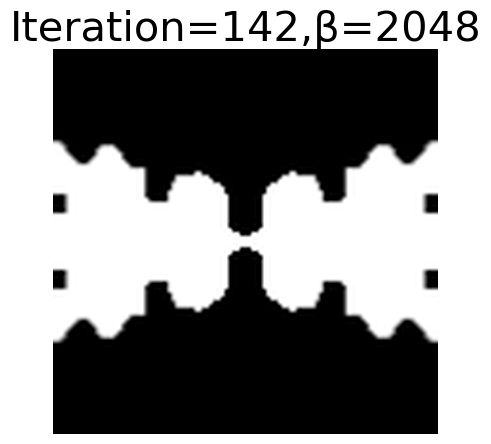

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
2048
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


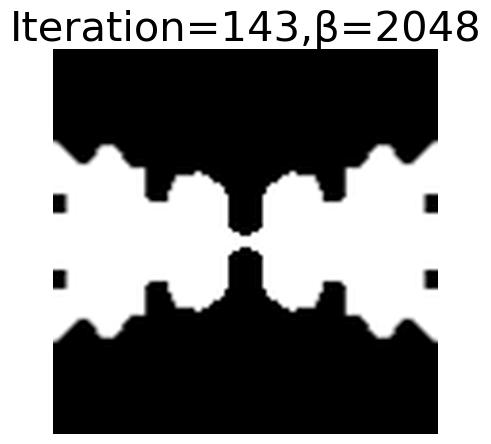

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
2048
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


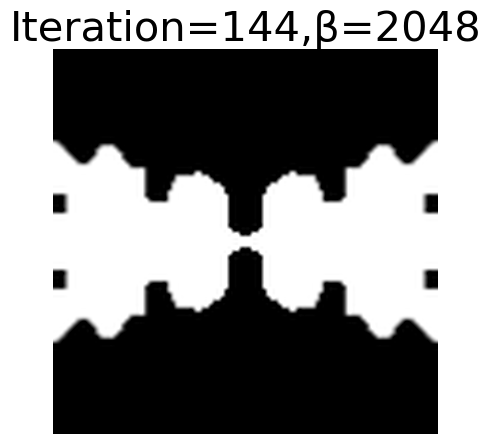

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
2048
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


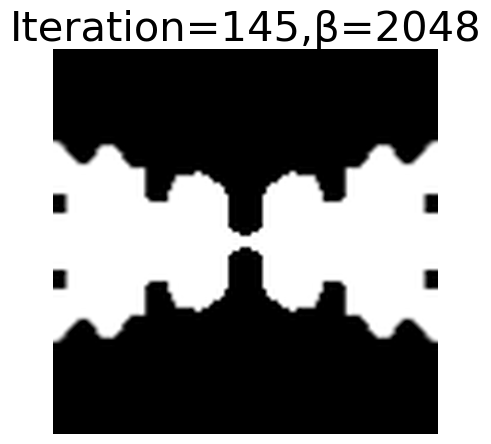

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
2048
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


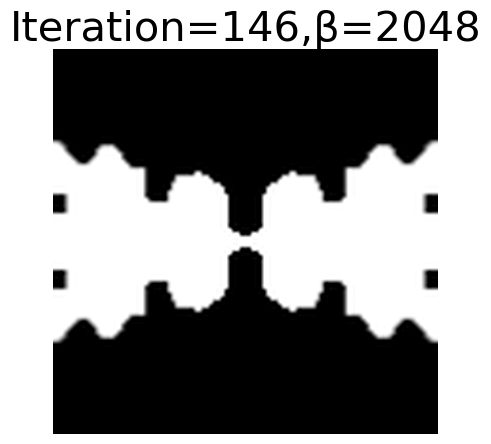

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
2048
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


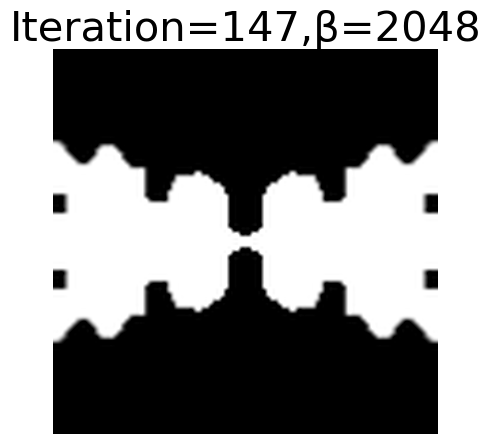

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
2048
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


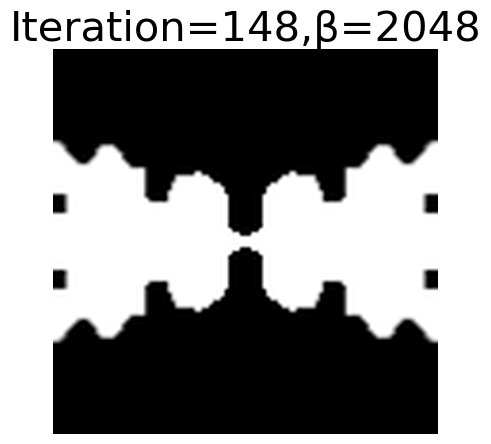

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
2048
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


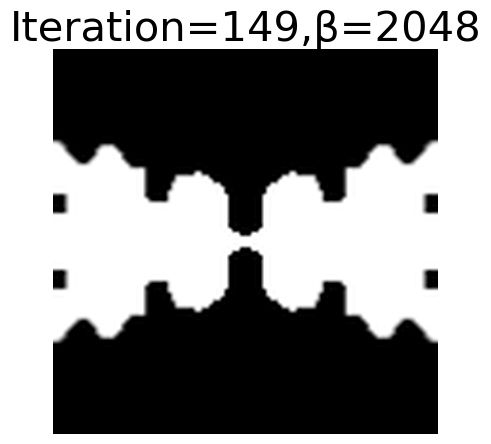

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
2048
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


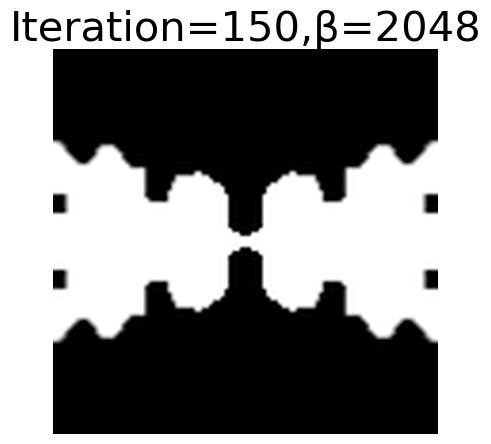

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
4096
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


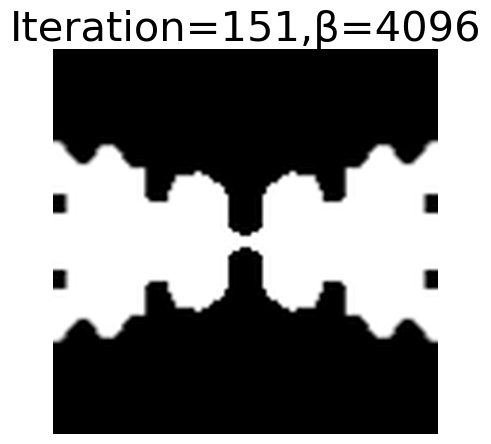

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
4096
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


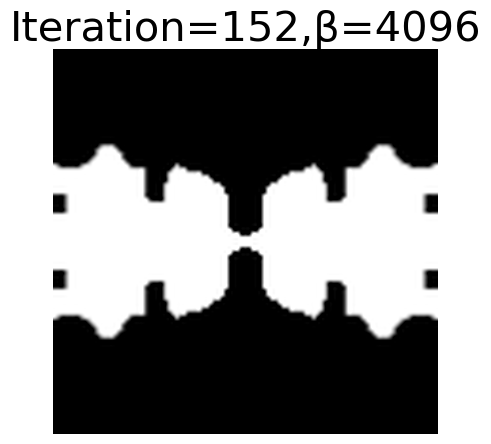

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
4096
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


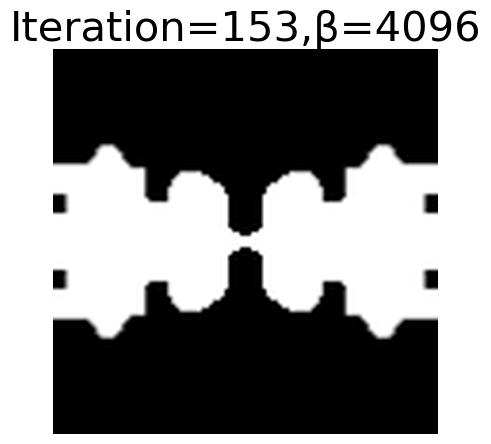

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
4096
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


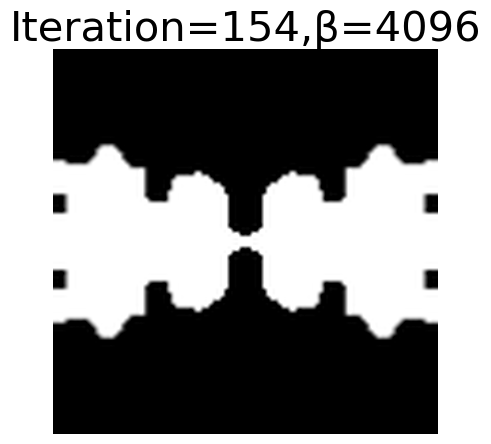

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
4096
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


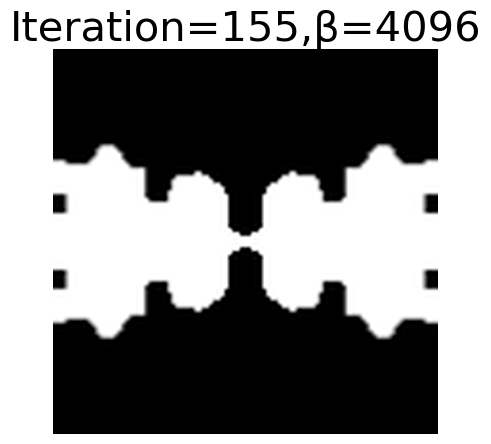

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
4096
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


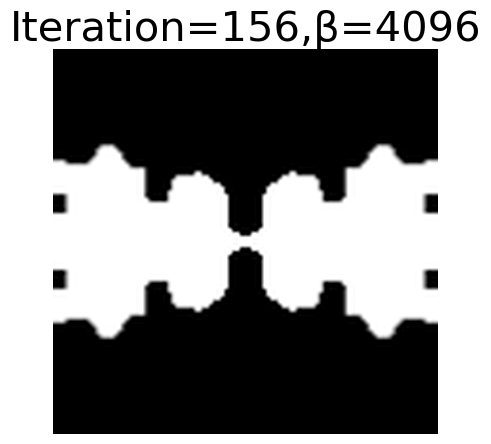

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
8192
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


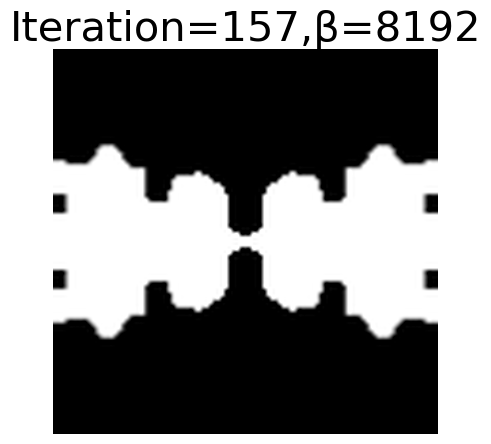

[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]
2
0.5
8192
[0.56497995 0.53670802 0.53866802 ... 0.53866802 0.53670802 0.56497995]


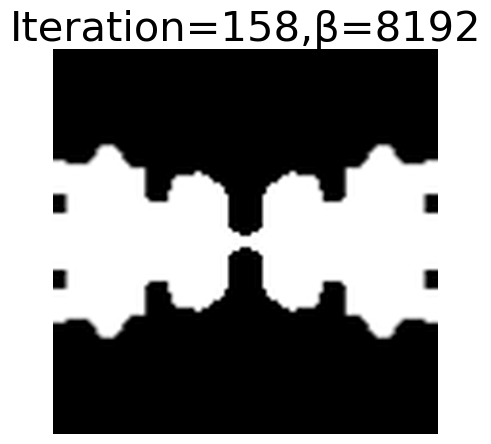

FileNotFoundError: [Errno 2] No such file or directory: 'Post_v_array159.npy'

In [3]:
for i in range(1,180):
    v_array = np.load(f'Post_v_array{i:03d}.npy')
    print(v_array)
    beta_A = np.load(f'Post_beta_scale_array{i:03d}.npy')
    print(beta_A)
    eta_A = np.load(f'Post_eta_i_array{i:03d}.npy')
    print(eta_A)
    cur_A = np.load(f'Post_cur_beta_array{i:03d}.npy')
    print(cur_A)
    x_A = np.load(f'Post_x_array{i:03d}.npy')
    print(x_A)
    


    opt.update_design([mapping(v_array, eta_A, cur_A/beta_A)]) # cur_beta/beta_scale is the final beta in the optimization.
    plt.figure(figsize=(5, 5))
    plt.title(f"Iteration={i :d},β={cur_A}", fontsize=30)
    ax = plt.gca()
    opt.plot2D(
        False,
        ax=ax,
        plot_sources_flag=False,
        plot_monitors_flag=False,
        plot_boundaries_flag=False,
        output_plane = mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(design_region_x_width, design_region_y_height, 0))
    )
    circ = Circle((2, 2), minimum_length / 2)
    ax.add_patch(circ)
    ax.axis("off")
    plt.savefig(f'PICTURE/Picture{i:03d}.png')
    plt.show()


    

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image

# Set the directory where your images are stored
image_folder = "PICTURE"
image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(".png")])  # Adjust for JPG, etc.

# Load images using PIL
images = [Image.open(img) for img in image_files]

# Create figure and axis
fig, ax = plt.subplots()
ax.axis("off")  # Hide axis
im = ax.imshow(images[0])  # Initialize with the first image

# Animation function
def update(frame):
    im.set_array(images[frame])
    return [im]

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(images), interval=200, blit=True)
plt.close(fig)
# Display in Jupyter Notebook
from IPython.display import HTML
HTML(ani.to_jshtml())


In [ ]:
# Convert images to GIF
output_gif = "animation.gif"

# Save images as an animated GIF
images[0].save(
    output_gif,
    save_all=True,
    append_images=images[1:],
    duration=200,  # 每幀持續時間 (毫秒)
    loop=0         # 0 表示無限循環
)

print(f"GIF 已儲存至 {output_gif}")